# Ames Housing Dataset - EDA

> Gianmaria Pizzo - 872966@stud.unive.it

These notebooks represent the project submission for the course [Data and Web Mining](https://www.unive.it/data/course/337525) by Professor [Claudio Lucchese](https://www.unive.it/data/people/5590426) at [Ca' Foscari University of Venice](https://www.unive.it).

---

## Structure of this notebook

This notebook covers the following points
* Univariate, Bivariate and Multivariate analysis
* Outliers removal
* Probability Distribution Check


# Explorative Data Analysis
The EDA is the first step to understanding the data and its nature. 

This includes analyzing the single features (Univariate Analysis), their interactions with the target (Bivariate Analysis) and their interactions with other features (Collinearity Check). 

During my exploration I will look out for possible outliers, correlation and any other statistically relevant problem that might affect my final prediction.

We will start with the environment.

### Environment

In [4]:
%matplotlib notebook

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
import IPython

sns.set()
plt.style.use('ggplot')
sns.set_style("darkgrid")
warnings.filterwarnings('ignore') 

### Dataset Loading

In [2]:
import os

# Working folder
WORKING_DIR = os.getcwd()
# Resources folder
RESOURCES_DIR = os.path.join(os.getcwd(), 'resources')
# Name of file
IN_LABEL = 'ames_housing_out_1.csv'

In [5]:
df = pd.read_csv(os.path.join(RESOURCES_DIR, IN_LABEL))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          2930 non-null   int64  
 1   MS_SubClass         2930 non-null   object 
 2   MS_Zoning           2930 non-null   object 
 3   Lot_Frontage        2930 non-null   float64
 4   Lot_Area            2930 non-null   float64
 5   Street              2930 non-null   object 
 6   Alley               2930 non-null   object 
 7   Lot_Shape           2930 non-null   object 
 8   Land_Contour        2930 non-null   object 
 9   Utilities           2930 non-null   object 
 10  Lot_Config          2930 non-null   object 
 11  Land_Slope          2930 non-null   object 
 12  Neighborhood        2930 non-null   object 
 13  Condition_1         2930 non-null   object 
 14  Condition_2         2930 non-null   object 
 15  Bldg_Type           2930 non-null   object 
 16  House_

In [3]:
def sort_alphabetically(dataset, last_label):
    # Sort
    dataset = dataset.reindex(sorted(dataset.columns), axis=1)
    # Move target column to last index
    col = dataset.pop(last_label)
    dataset.insert(dataset.shape[1], last_label, col)
    return dataset

In [4]:
df=sort_alphabetically(df, 'Sale_Price')

Well, we are ready to start.

---

# Explorative Data Analysis

# Univariate Analysis
We perform an analysis of the features to remove outliers, and to add possible new features.

We want to compare their distribution to a Normal Uniform distribution, so that the variance will be reduced.

### Outliers
We can think of outliers as influential points that can be seen as *exceptions or rare cases* which have a great impact on our estimations and might be the cause of an increased variance in our results. 

Since we have a great deal of different features there could be many outliers for each one of them when taken one by one. Conversely, this might not be real outliers in the p-dimensional space (considering p predictors).

Since we want to reduce the variance we might as well take our chances and define a general rule to assess outliers, so that our possible error will be uniformly applied to each one of the features and we will be consistent. Again, this might not be possible for each feature as we need to consider the context.

In [344]:
def get_df_wo_outliers(dataset, label, threshold=[0.5,99.5]):
    if dataset[label].dtype != object:
        stats_dict = dataset[label].describe().to_dict()
        if len(threshold) == 2:
            uppr = np.percentile(dataset[label].values, threshold[1])
            lwr = np.percentile(dataset[label].values, threshold[0])
            return dataset.loc[(dataset[label] >= lwr) & (dataset[label] < uppr)]
        else:
            raise Exception("Threshold must be an integer list of 2 integers or 2 floats")
    else:
        raise Exception("Categorical features are not allowed")

In [345]:
from scipy.stats import probplot

def numeric_distr_plot(dataset, label, shape=(9.8, 6)):
    """
    Plots a
    :param dataset:
    :param label:
    :param shape:
    :param hue:
    :return:
    """
    # Normal Distribution fit
    (mu, sigma) = stats.norm.fit(dataset[label])

    # Feature Distribution Plot
    plt.figure(figsize=shape)
    sns.distplot(dataset[label], hist=True, kde=True, fit=stats.norm, color='cornflowerblue')
    
    # Figure labels
    plt.title(label.replace("_", " ") + '\'s Distribution vs Normal Distribution', fontsize=14)
    plt.xlabel(label.replace("_", " "))
    plt.ylabel('Frequency in %')
    plt.legend(['Normal Dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='upper right')
    plt.show()
    pass

def probability_plot(dataset, target):
    fig = plt.figure()
    res = stats.probplot(dataset[target], plot=plt)
    plt.show()
    pass

def scatterplot_distr(dataset, label, shape=(9.8, 6)):
    plt.figure(figsize=shape)
    plt.scatter(range(dataset[label].shape[0]), np.sort(dataset[label].values))
    plt.title(label + '\'s Scatter Plot')
    plt.xlabel('Index', fontsize=12)
    plt.ylabel(label, fontsize=12)
    plt.show()
    pass

### Sale Price

<IPython.core.display.Javascript object>


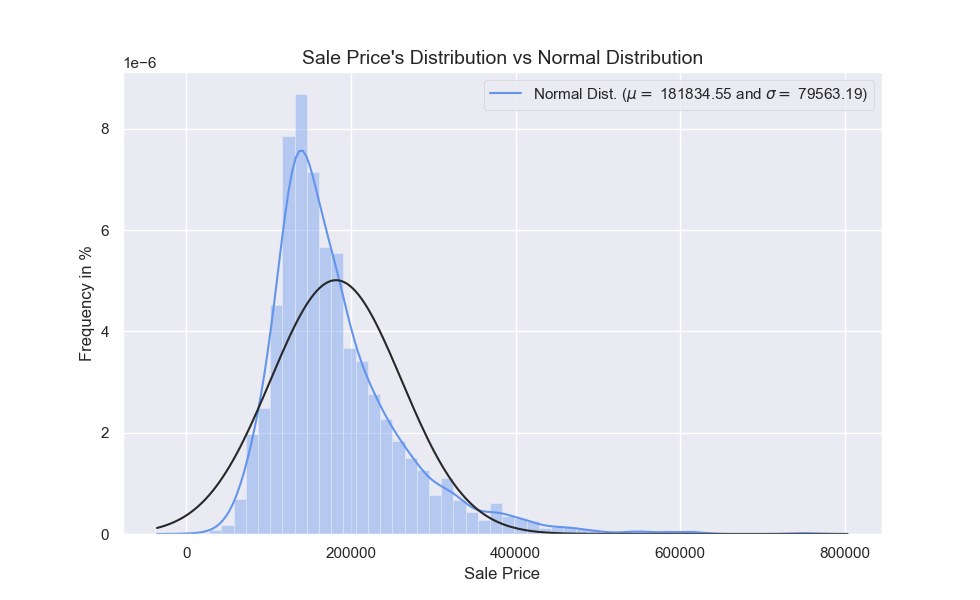

In [346]:
numeric_distr_plot(df, 'Sale_Price')

As we can see the sample distribution highlights quite heavy left tail. As the distribution is similar to a log-normal distribution, let's try and apply this transformation.

<IPython.core.display.Javascript object>


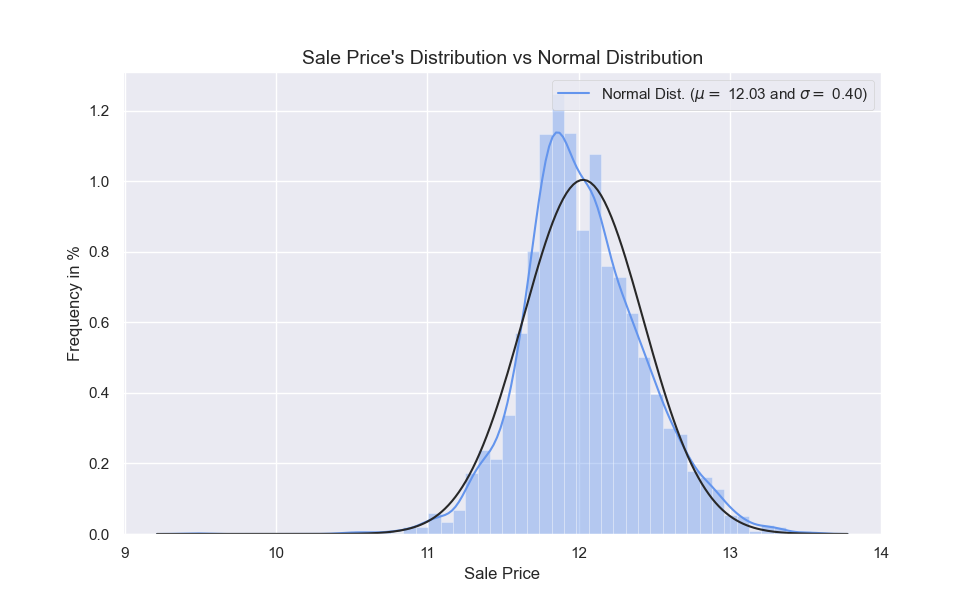

In [347]:
df['Sale_Price'] = np.log1p(df['Sale_Price'])
numeric_distr_plot(df, 'Sale_Price')

Let us look at the distribution without those outliers

<IPython.core.display.Javascript object>


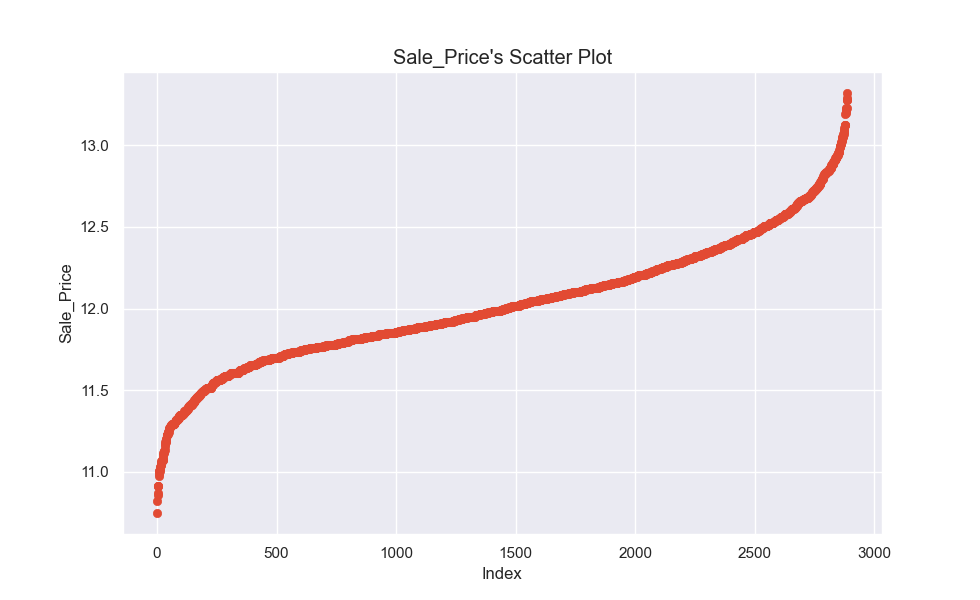

In [348]:
# Seems like a good starting point given that the distribution tends to be left-skewed
df_wo_outliers = get_df_wo_outliers(df, 'Sale_Price', threshold=[0.15,99.85])

scatterplot_distr(df_wo_outliers, 'Sale_Price')

<IPython.core.display.Javascript object>


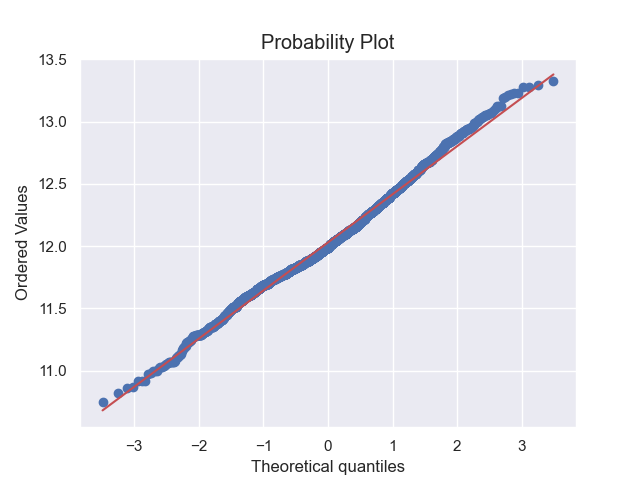

In [349]:
probability_plot(df_wo_outliers, 'Sale_Price')

Since the distribution and the probability plots show a great improvement, we will keep using the logarithm transformation for our prediction.

In [350]:
df = df_wo_outliers

### Above Ground Living Area

<IPython.core.display.Javascript object>


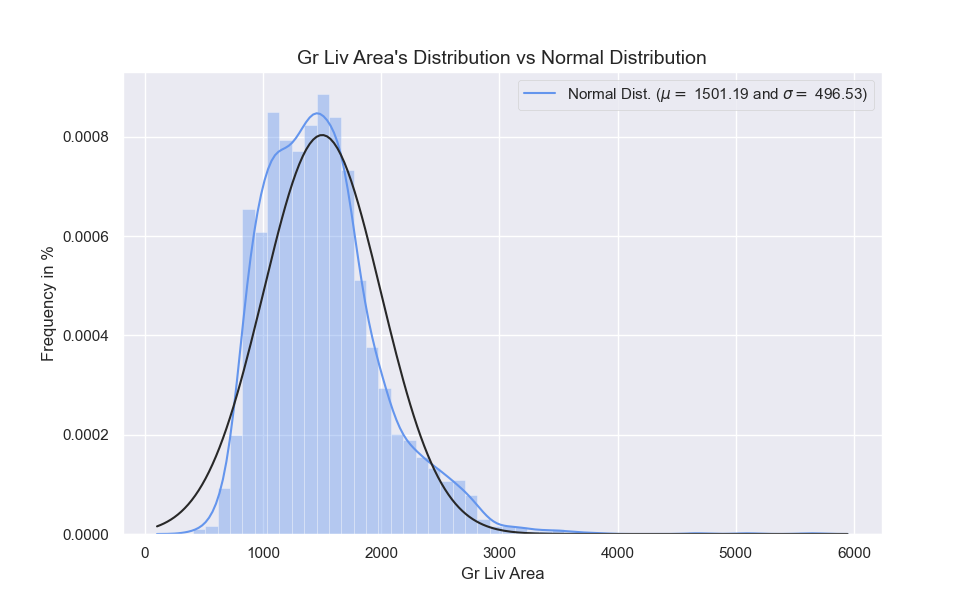

In [351]:
numeric_distr_plot(df, 'Gr_Liv_Area')

It seems like we could use our log-transformation again

<IPython.core.display.Javascript object>


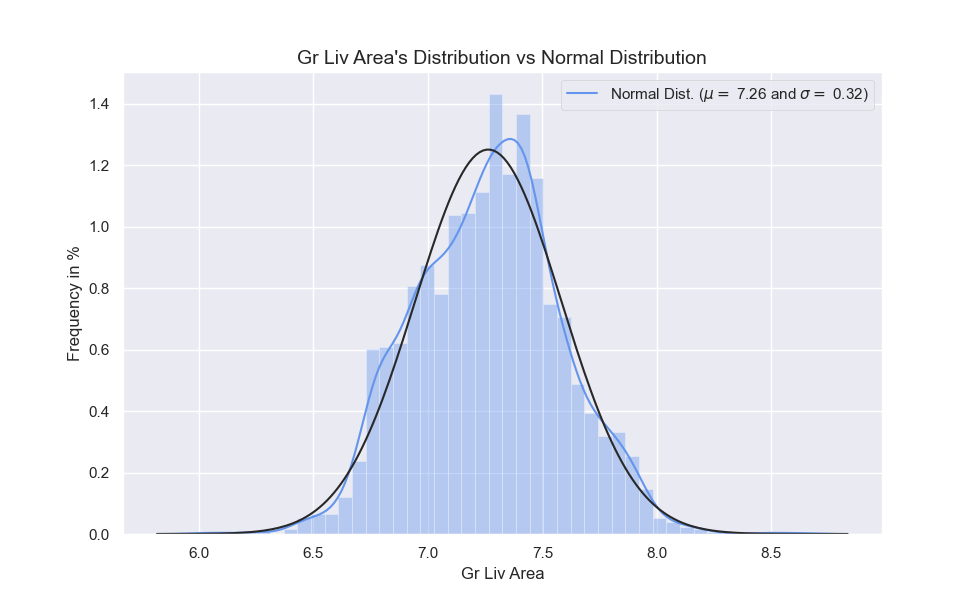

In [352]:
df['Gr_Liv_Area'] = np.log1p(df['Gr_Liv_Area'])
numeric_distr_plot(df, 'Gr_Liv_Area')

<IPython.core.display.Javascript object>


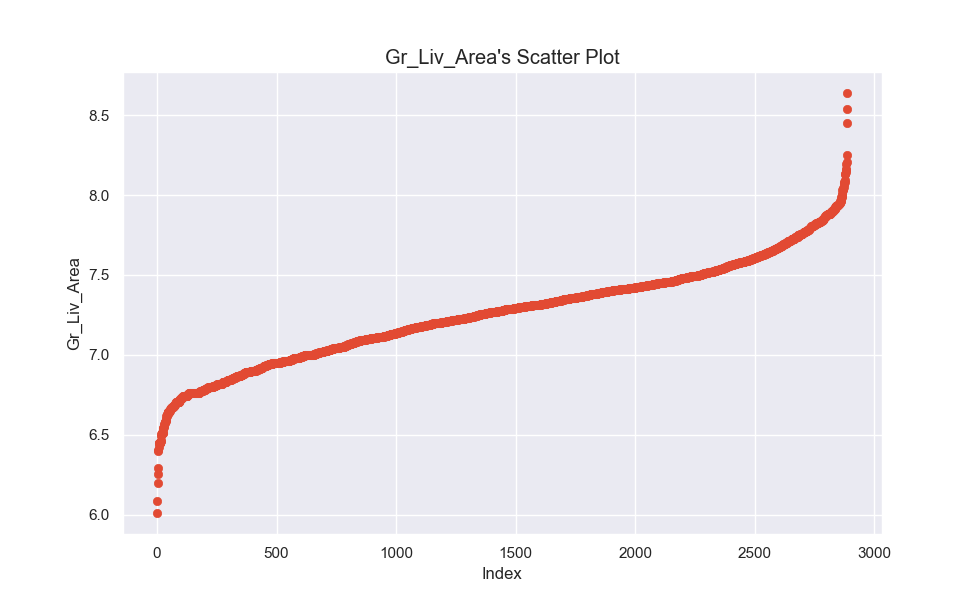

In [353]:
scatterplot_distr(df, 'Gr_Liv_Area')

The distribution shows some problematic points.

<IPython.core.display.Javascript object>


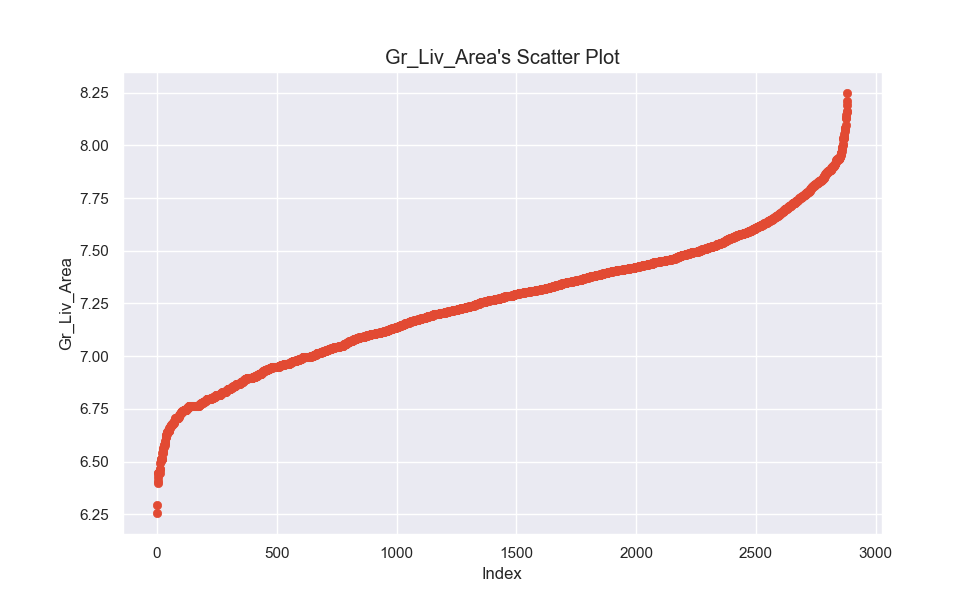

In [354]:
scatterplot_distr(get_df_wo_outliers(df, 'Gr_Liv_Area', threshold=[0.10,99.90]), 'Gr_Liv_Area')

In [355]:
# Improvement so we will keep this
df= get_df_wo_outliers(df, 'Gr_Liv_Area', threshold=[0.10,99.90])

<IPython.core.display.Javascript object>


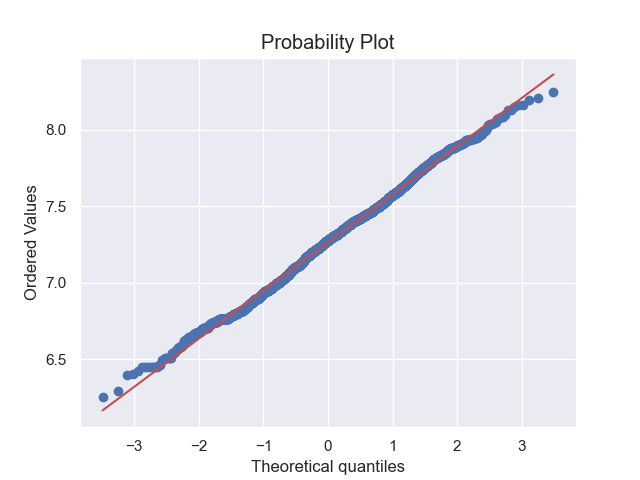

In [356]:
probability_plot(df, 'Gr_Liv_Area')

### Lot Area

<IPython.core.display.Javascript object>


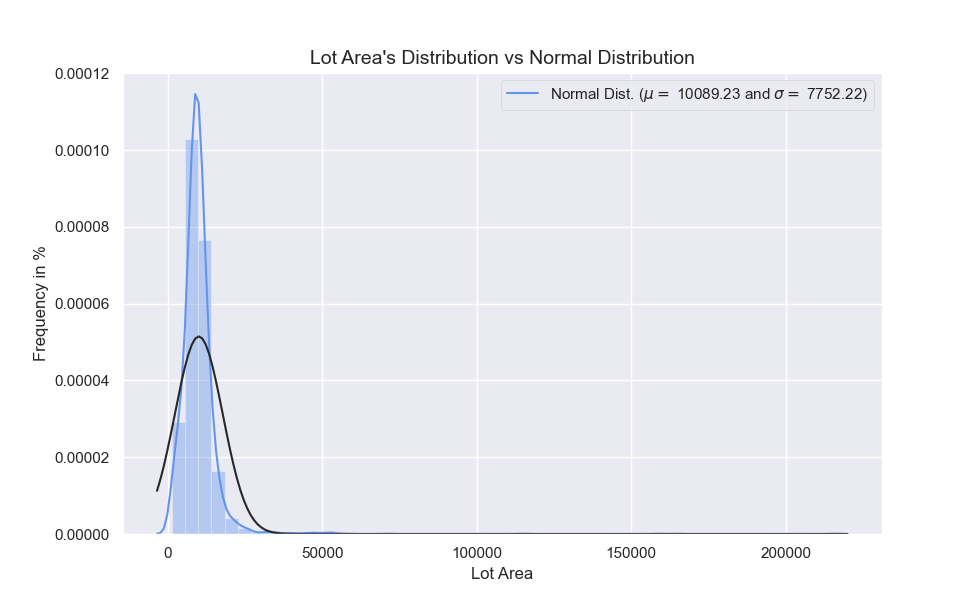

In [357]:
numeric_distr_plot(df, 'Lot_Area')

This looks ugly let us see what the skewness is here

<IPython.core.display.Javascript object>


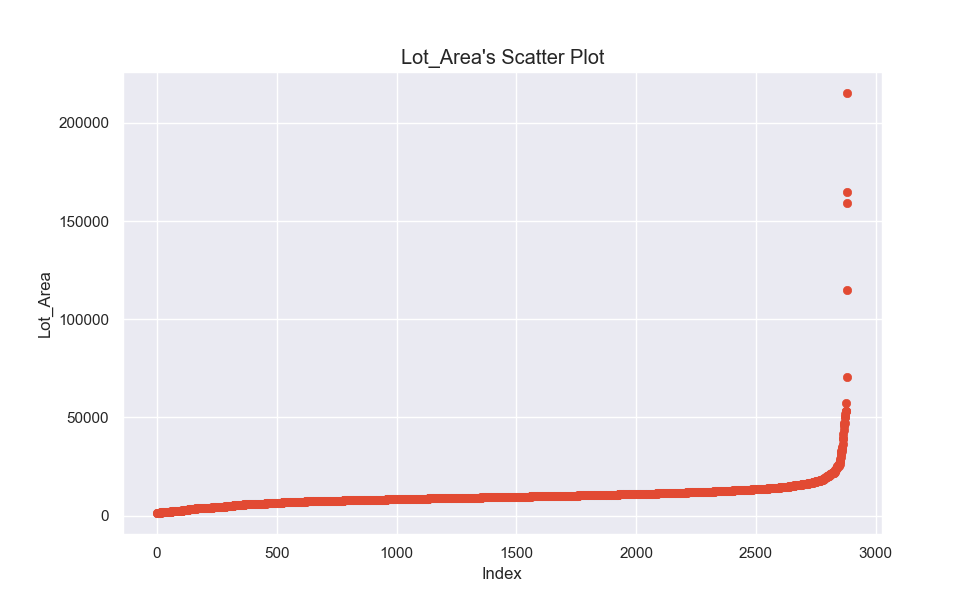

In [358]:
scatterplot_distr(df, 'Lot_Area')

In [360]:
# Removing obvious outliers
df.drop(df[df['Lot_Area']>50000].index.tolist(),inplace=True)

<IPython.core.display.Javascript object>


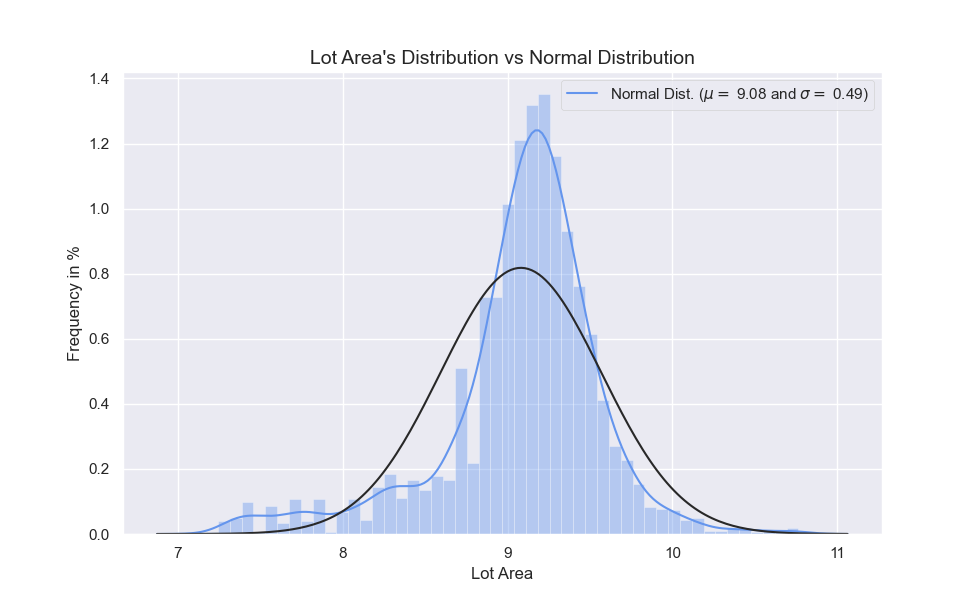

In [361]:
df['Lot_Area'] = np.log1p(df['Lot_Area'])
numeric_distr_plot(df, 'Lot_Area')

Well this looks like a tough distribution to center as the left tail is surprisingly big.

<IPython.core.display.Javascript object>


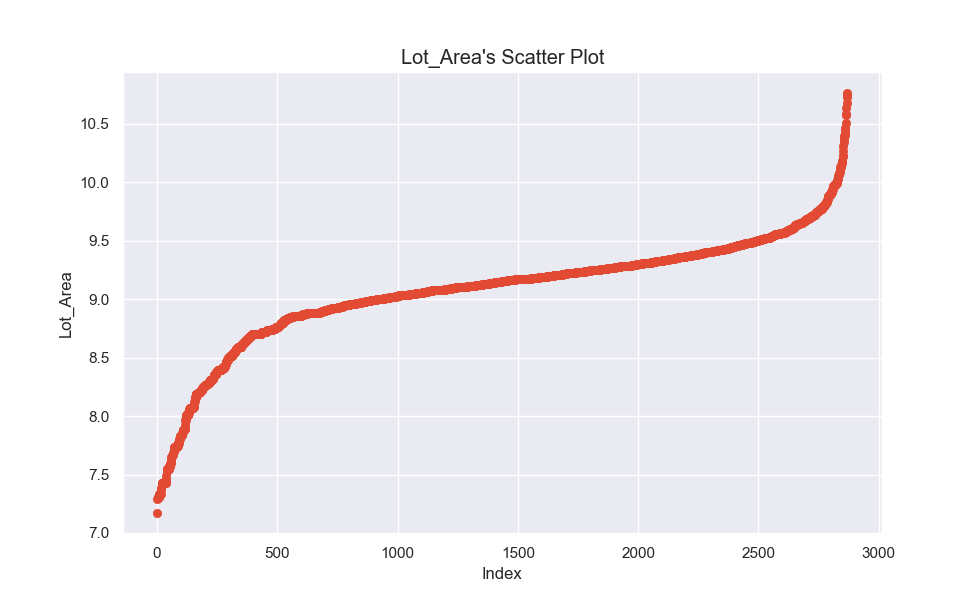

In [364]:
scatterplot_distr(df, 'Lot_Area')

This is the best we can do for now

### First Floor SquareFeet

<IPython.core.display.Javascript object>


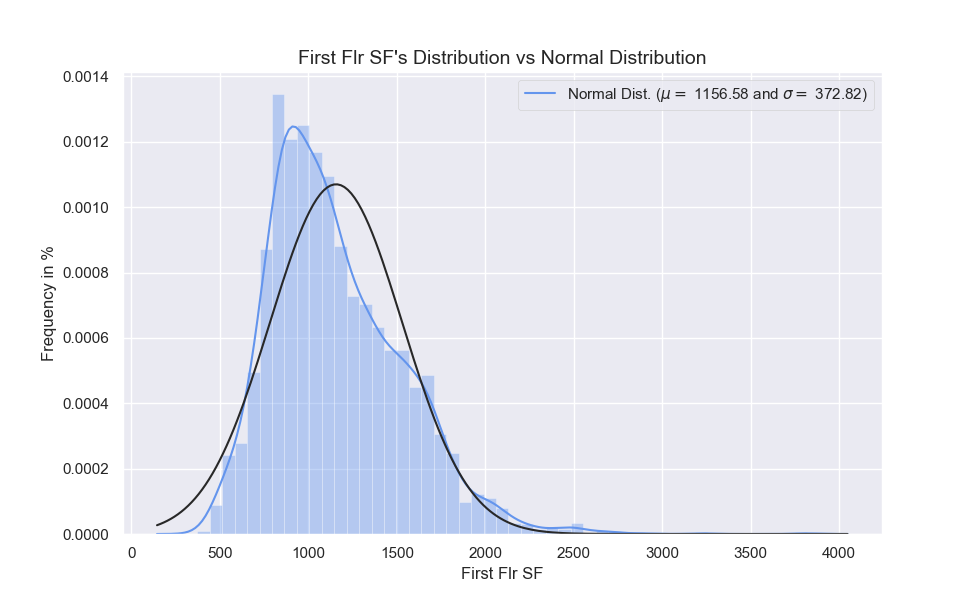

In [365]:
numeric_distr_plot(df, 'First_Flr_SF')

In [366]:
df['First_Flr_SF'] = np.log1p(df['First_Flr_SF'])

<IPython.core.display.Javascript object>


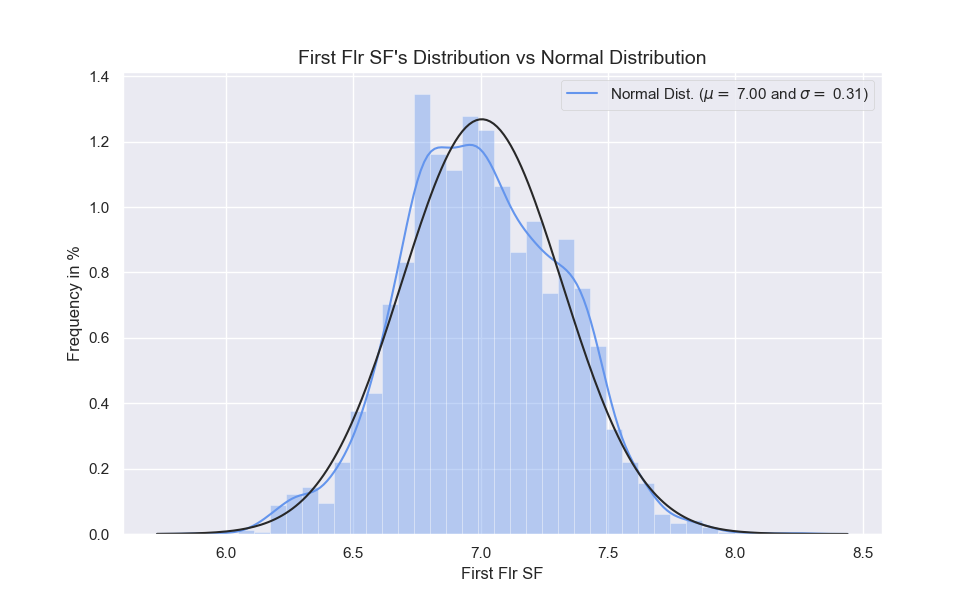

In [367]:
numeric_distr_plot(df, 'First_Flr_SF')

<IPython.core.display.Javascript object>


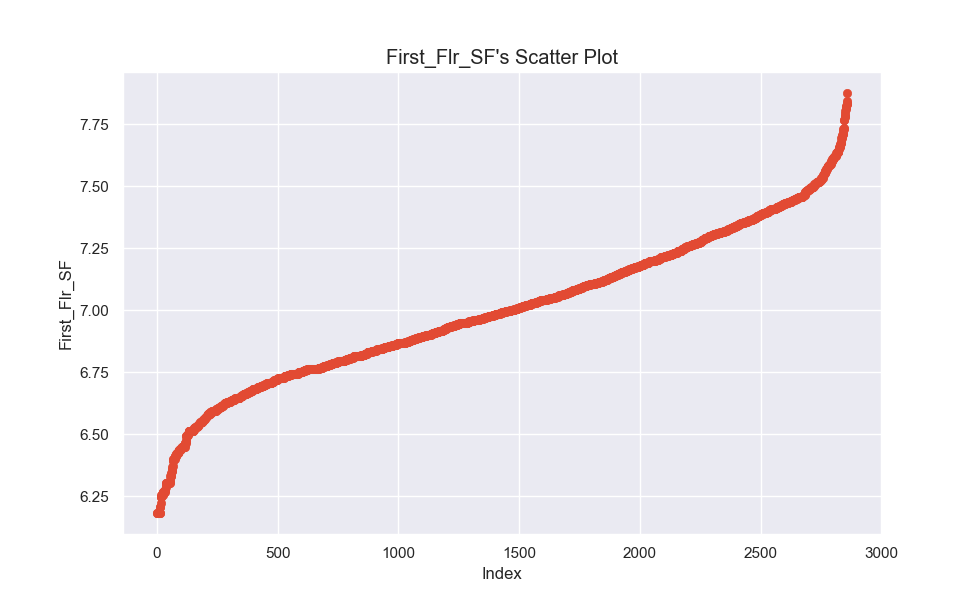

In [368]:
scatterplot_distr(get_df_wo_outliers(df, 'First_Flr_SF', threshold=[0.2,99.8]), 'First_Flr_SF')

In [369]:
df = get_df_wo_outliers(df, 'First_Flr_SF', threshold=[0.2,99.8])

<IPython.core.display.Javascript object>


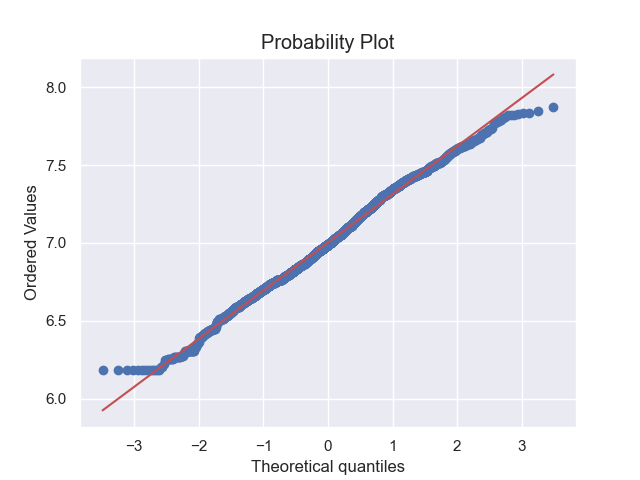

In [370]:
probability_plot(df, 'First_Flr_SF')

This looks exactly like we wanted, with some minor issues. Therefore we will apply the same tranformation to `Second_Flr_SF`

In [371]:
df['Second_Flr_SF'] = np.log1p(df['Second_Flr_SF'])

### Total Basement Square Feet and related features

<IPython.core.display.Javascript object>


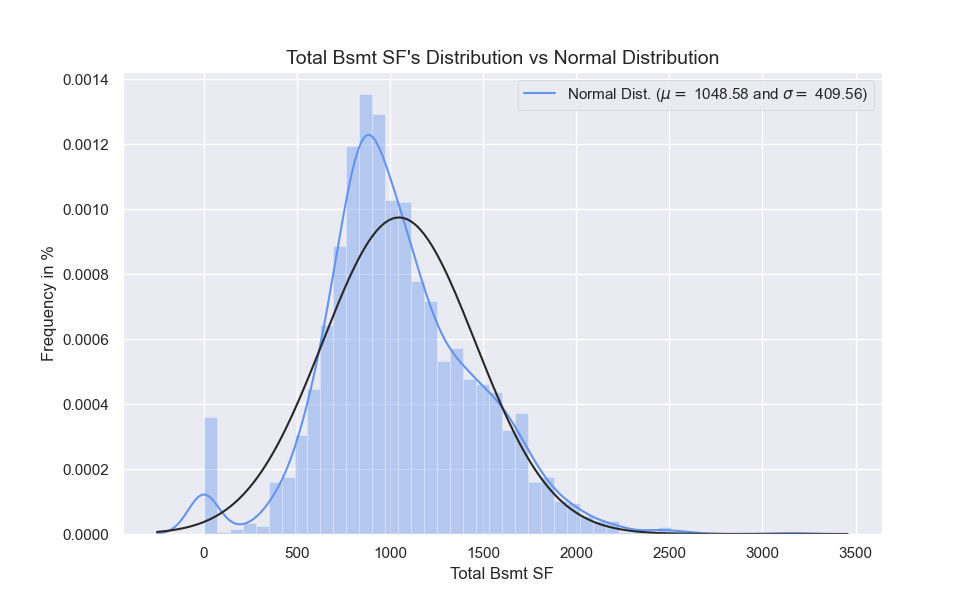

In [372]:
numeric_distr_plot(df, 'Total_Bsmt_SF')

The left tail shows a great issue when it comes to the value `0`. Since we have an indicator value that speciefies whether a basement is present or not we will use it to see how the houses with a basement are distributed after a log transformation.

<IPython.core.display.Javascript object>


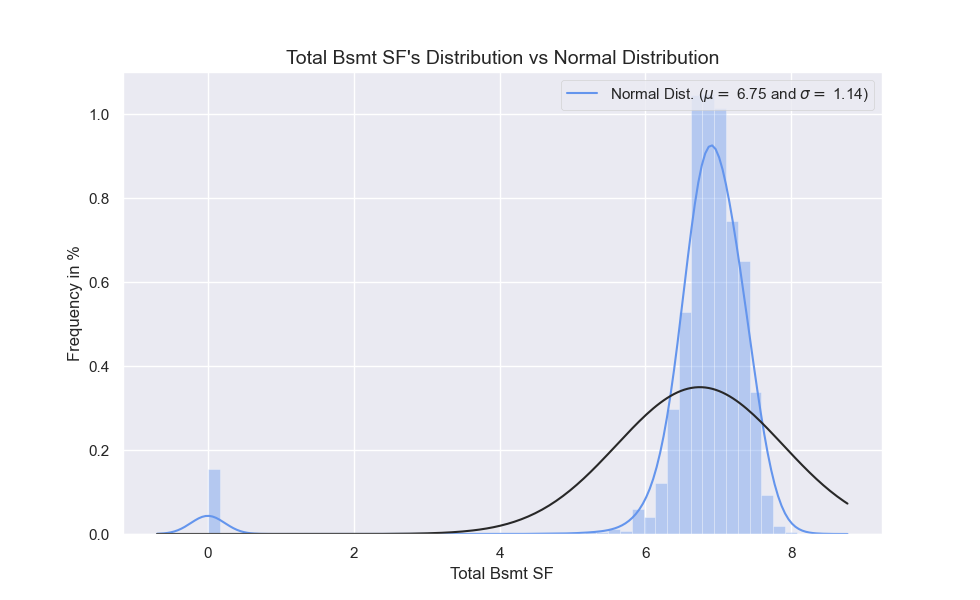

In [373]:
df['Total_Bsmt_SF'] = np.log1p(df['Total_Bsmt_SF'])
numeric_distr_plot(df, 'Total_Bsmt_SF')

Obviously we should look at the distribution when the basement is present 

<IPython.core.display.Javascript object>


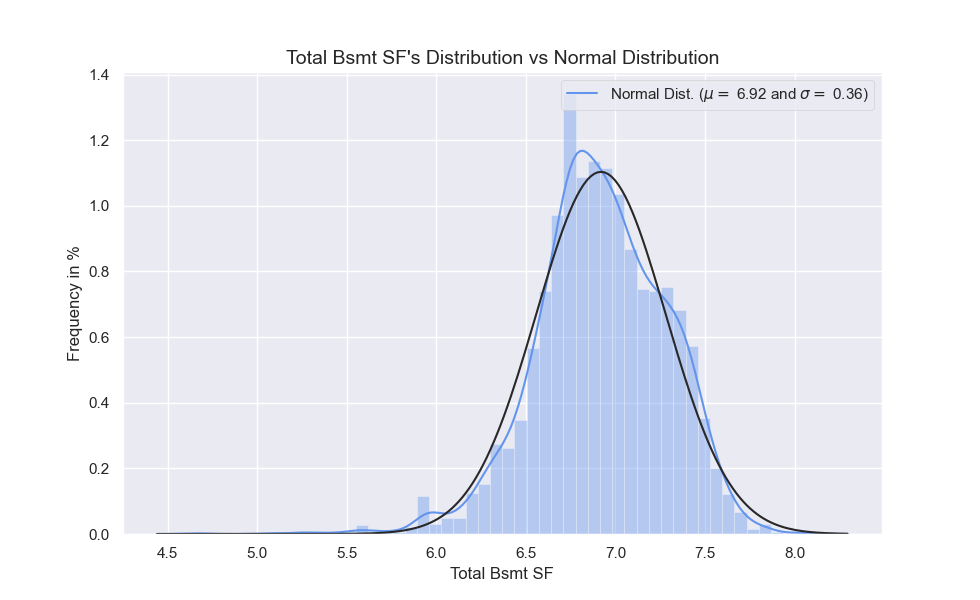

In [375]:
numeric_distr_plot(df.drop(df[df['Bsmt']==0].index.tolist()), 'Total_Bsmt_SF')

This is definitely what we are aming for!

<IPython.core.display.Javascript object>


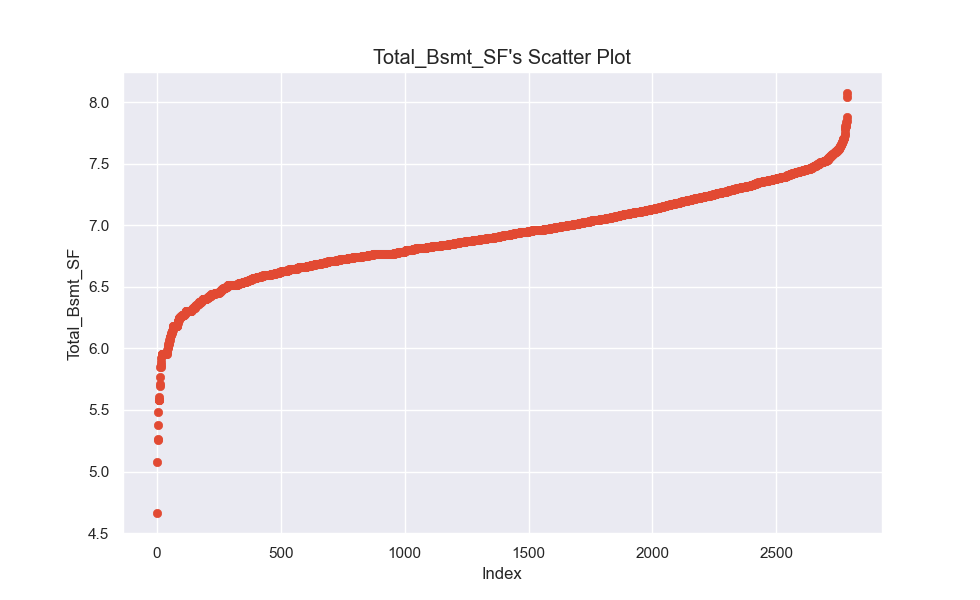

In [376]:
scatterplot_distr(df.drop(df[df['Bsmt']==0].index.tolist()), 'Total_Bsmt_SF')

We can remove those ugly outliers on the right side

In [377]:
df.drop(df[((df['Total_Bsmt_SF']>8.0) |(df['Total_Bsmt_SF']<=5.5) & df['Bsmt'] !=0)].index.tolist(), inplace=True)

<IPython.core.display.Javascript object>


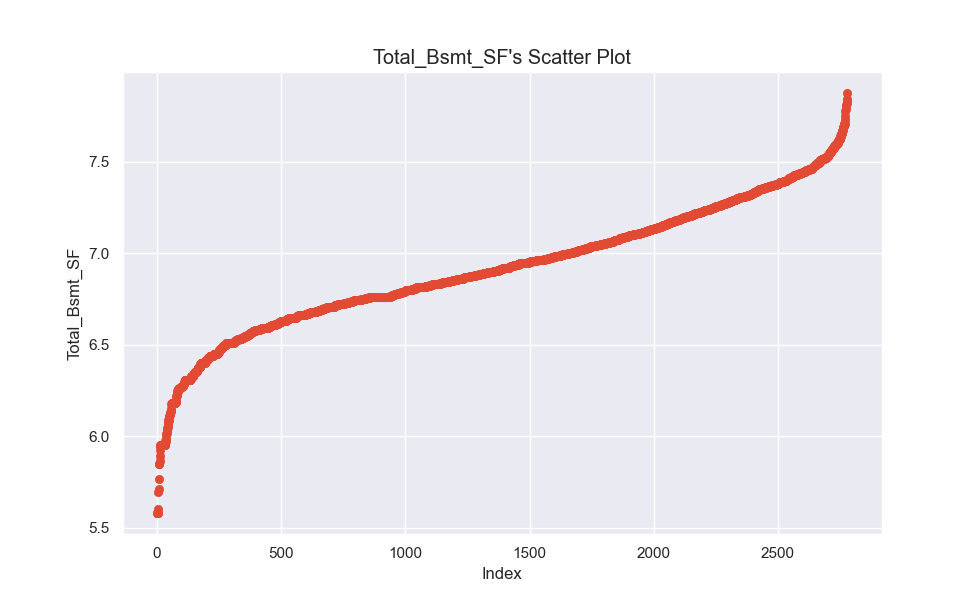

In [381]:
scatterplot_distr(df.drop(df[df['Bsmt']==0].index.tolist()), 'Total_Bsmt_SF')

## Basement Unfinished

<IPython.core.display.Javascript object>


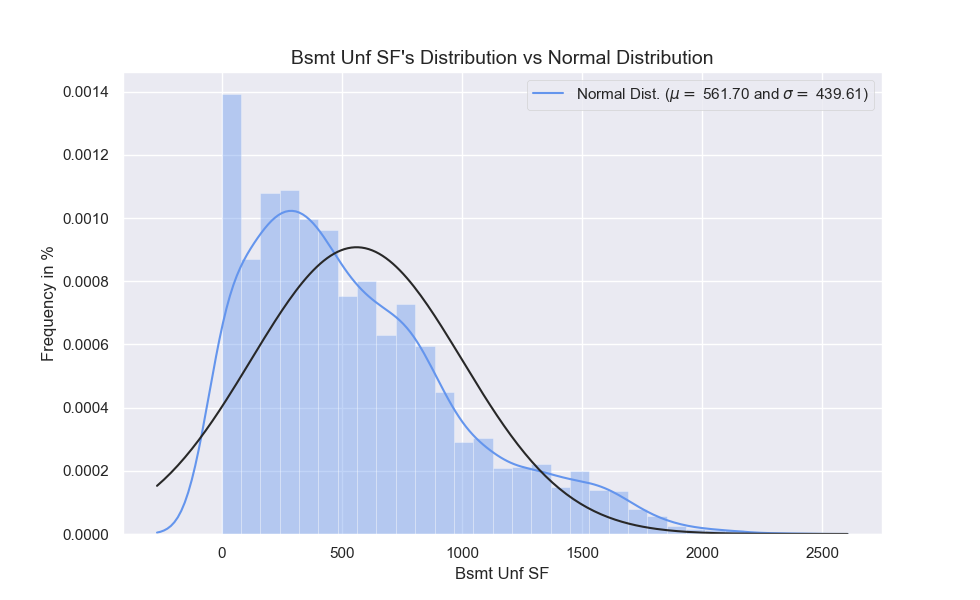

In [382]:
numeric_distr_plot(df, 'Bsmt_Unf_SF')

In [383]:
df['Bsmt_Unf_SF'] = np.log1p(df['Bsmt_Unf_SF'])

<IPython.core.display.Javascript object>


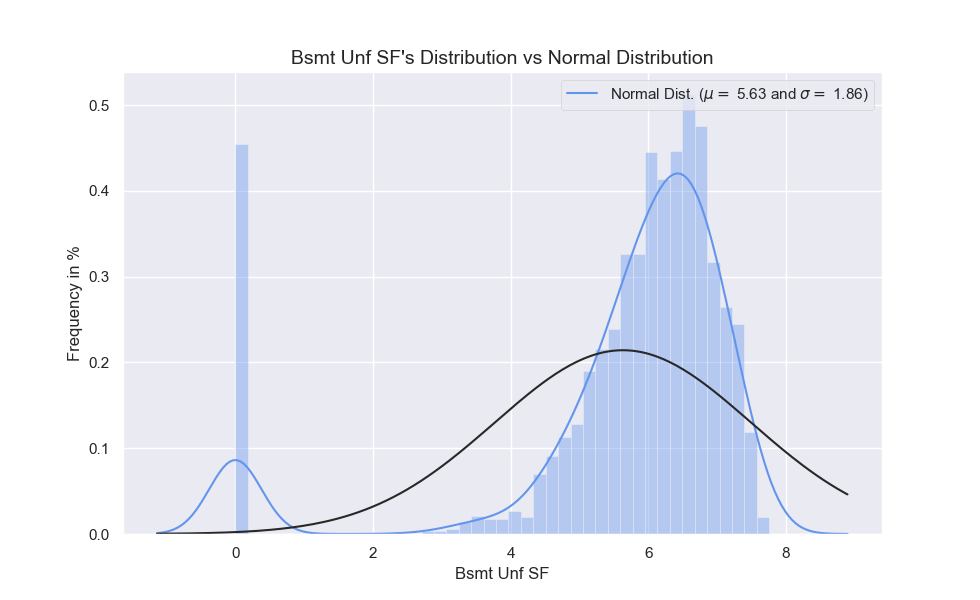

In [384]:
numeric_distr_plot(df, 'Bsmt_Unf_SF')

The shape does get some improvements but we still have issues when it comes to `0.0`

### Garage Area

<IPython.core.display.Javascript object>


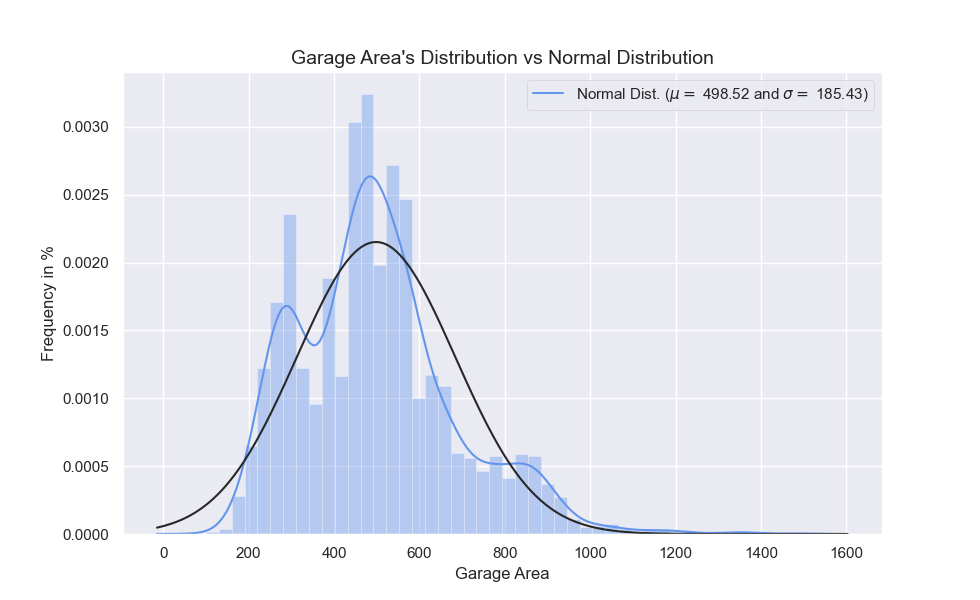

In [385]:
numeric_distr_plot(df.drop(df[df['Garage']==0].index.tolist()), 'Garage_Area')

This is an interesting pattern that we will study later with a bivariate analysis

# Bivariate Analysis

## Correlation

Before choosing what features to inspect in depth, we look at the correlation and we discard the outliers.
Furthermore if we find that a transformation or a new feature could represent a better fit, we will add it and try to see how that would be of use.

In [386]:
def display_corr_matrix(dataset, label):
    # Move target column to last index
    col = dataset.pop(label)
    dataset.insert(dataset.shape[1], label, col)

    plt.figure(figsize=(20,20))
    
    matrix = dataset.corr()

    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                                 n=9, center="light", as_cmap=True)

    mask = np.triu(np.ones_like(matrix, dtype=bool))

    sns.heatmap(matrix, mask=mask, center=0, annot=True,
                 fmt='.2f', square=True, cmap=cmap)
    return matrix


def top_correlated_features(corr_matrix, label, threshold=0.45):
    m = corr[label].sort_values(ascending=False).to_dict()
    corr_dict = {}
    
    for k in m:
        if label in k:
            continue
        else:
            v = m.get(k)
            if v >= threshold or v <= (-threshold):
                corr_dict.update({k:v})
    return corr_dict


def display_correlation(sample_dict, exclude=None):
    for k in sample_dict:
        print("Top correlated features with \"{0}\"".format(k))
        temp = top_correlated_features(corr, k, .60)
        for k in temp:
            if exclude is not None and k in exclude:
                continue
            print("\t{0} : {1}".format(k, temp.get(k)))
        print("\n")
    pass

<IPython.core.display.Javascript object>


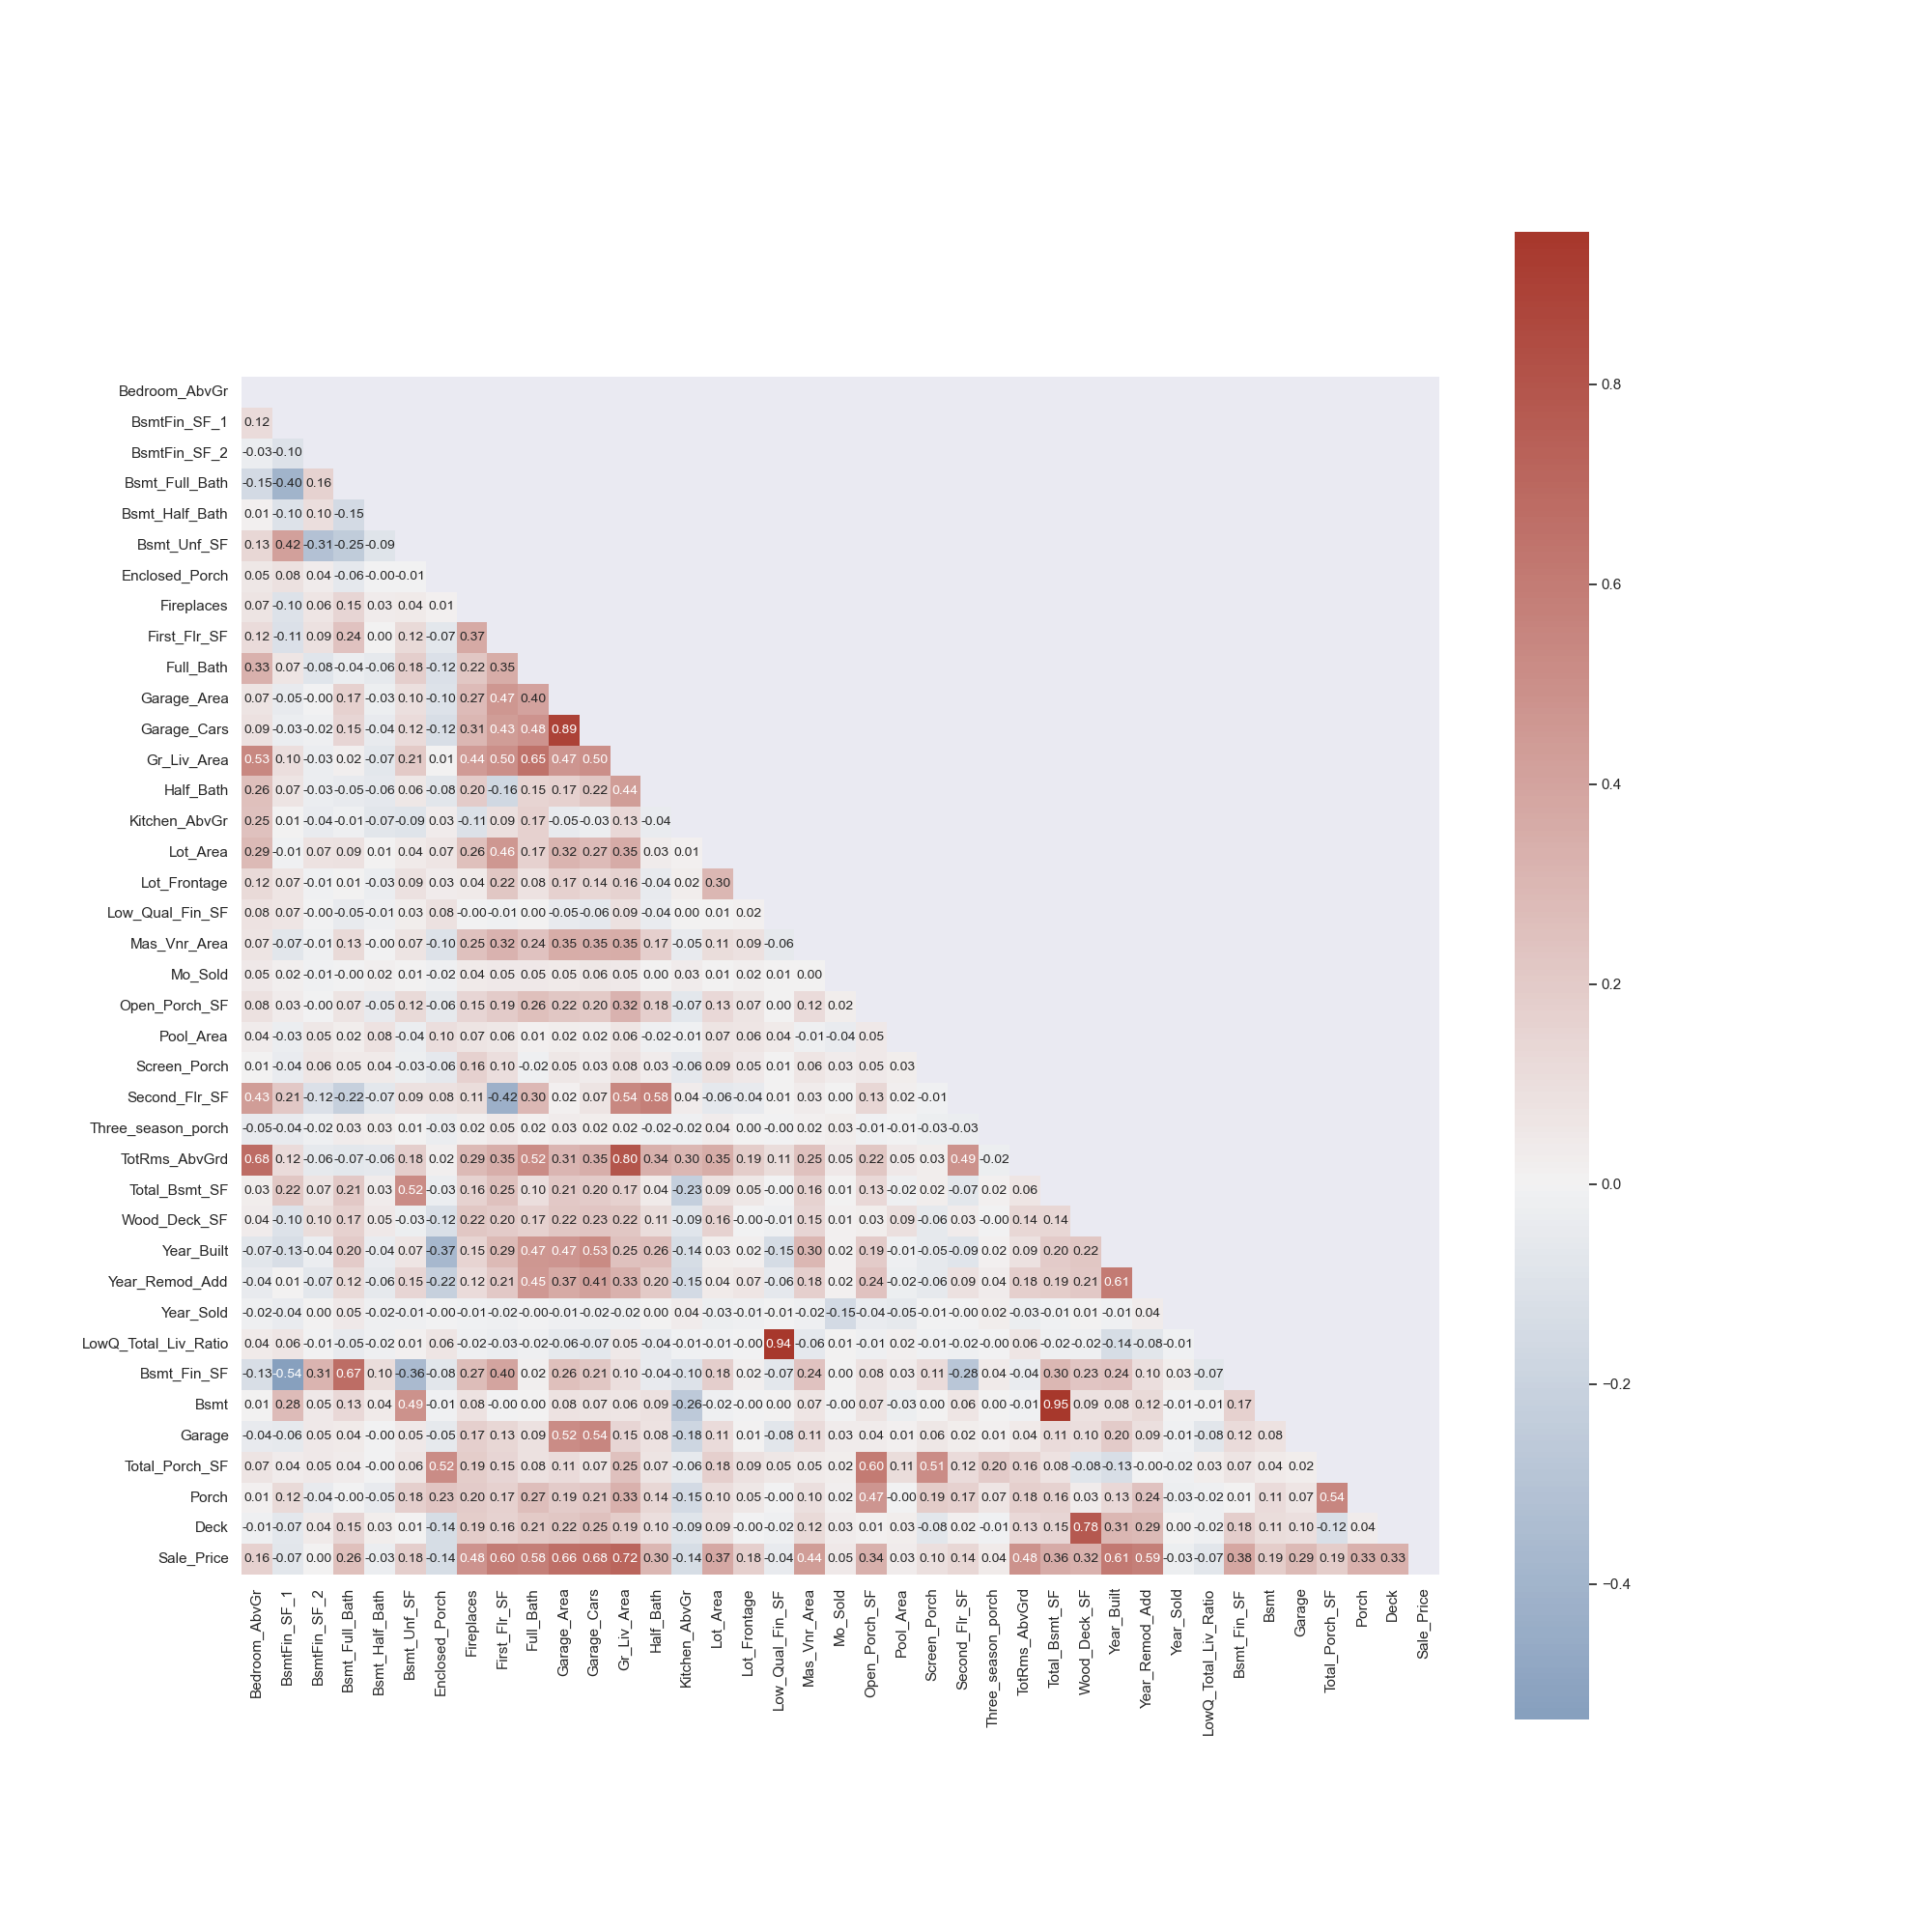

In [387]:
corr = display_corr_matrix(df, label='Sale_Price')

In [388]:
top_corr_dict = top_correlated_features(corr, 'Sale_Price', 0.40)
top_corr_dict

{'Gr_Liv_Area': 0.7189360066655524,
 'Garage_Cars': 0.6822602972972808,
 'Garage_Area': 0.6640462022345284,
 'Year_Built': 0.6139256560659067,
 'First_Flr_SF': 0.5977146169385499,
 'Year_Remod_Add': 0.5863118537080232,
 'Full_Bath': 0.580906575947987,
 'TotRms_AbvGrd': 0.4830393319299451,
 'Fireplaces': 0.4804853828107564,
 'Mas_Vnr_Area': 0.4406098126763188}

We must pay attention to the ones who show collinearity as they might disturb our prediction. We should investigate the relationships of high correlation between other variables.

In [389]:
display_correlation(top_corr_dict, exclude='Sale_Price')

Top correlated features with "Gr_Liv_Area"
	TotRms_AbvGrd : 0.7982619341109316
	Full_Bath : 0.649626293974084


Top correlated features with "Garage_Cars"
	Garage_Area : 0.8898706273622402


Top correlated features with "Garage_Area"
	Garage_Cars : 0.8898706273622402


Top correlated features with "Year_Built"
	Year_Remod_Add : 0.6084624451161421


Top correlated features with "First_Flr_SF"


Top correlated features with "Year_Remod_Add"
	Year_Built : 0.6084624451161421


Top correlated features with "Full_Bath"
	Gr_Liv_Area : 0.649626293974084


Top correlated features with "TotRms_AbvGrd"
	Gr_Liv_Area : 0.7982619341109316
	Bedroom_AbvGr : 0.682824790695694


Top correlated features with "Fireplaces"


Top correlated features with "Mas_Vnr_Area"




Now that we saw what features are highly correlated with Sale_Price, we will take a closer look at them.:
* `Gr_Liv_Area`
* `Garage_Cars`
* `Garage_Area`
* `Total_Bsmt_SF`
* `First_Flr_SF`
* `Year_Built`
* `Full_Bath`
* `Year_Remod_Add`
* `Mas_Vnr_Area`
* `TotRms_AbvGrd`
* `Fireplaces`

But first I want to confirm that the following ones also matter, since this is what we obtained from domain knowledge research:
* Lot Area
* Year and Month of Sale
* Neighborhood

Finally, we shall look at the categorical features too.

In [390]:
def scatterplot_single(dataset, target, label, hue=None):
    sns.lmplot(data=dataset, x=target, y=label, aspect=1.5, scatter=True, hue=hue)
    pass

In [391]:
def scatterplot_multiple(dataset, target, labels, plot_cols=1, notebook_fig_size=None, adjust=None, hue=None):

    fig, axes = plt.subplots(nrows = int(np.ceil(len(labels)/plot_cols)), ncols = plot_cols)

    # Flat 1-D flat iterator over the array.
    axes = axes.flatten()

    # Notebook figure dimensions
    if notebook_fig_size is None:
        # Default
        fig.set_size_inches(9, 8*plot_cols)
    else:
        fig.set_size_inches(notebook_fig_size.get('width'), notebook_fig_size.get('height'))

    # Plot 
    for ax, col in zip(axes, dataset.loc[:, dataset.columns.isin(labels)].columns):
        sns.regplot(data=dataset, x=target, y=col, fit_reg=True, scatter=True, ax=ax)
        ax.set_title(col + " vs " + target, fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel(target)

    # Adjust 
    if adjust is None:
        # Default
        plt.subplots_adjust(left=0.2, right=0.9, top=0.95, bottom=0.1, wspace=0.4, hspace=0.5)
    else:
        plt.subplots_adjust(left=adjust.get('left'), right=adjust.get('right'), 
                            top=adjust.get('top'), bottom=adjust.get('bottom'),
                            wspace=adjust.get('wspace'), hspace=adjust.get('hspace'))
    pass

## Lot Area vs Sale Price

<IPython.core.display.Javascript object>


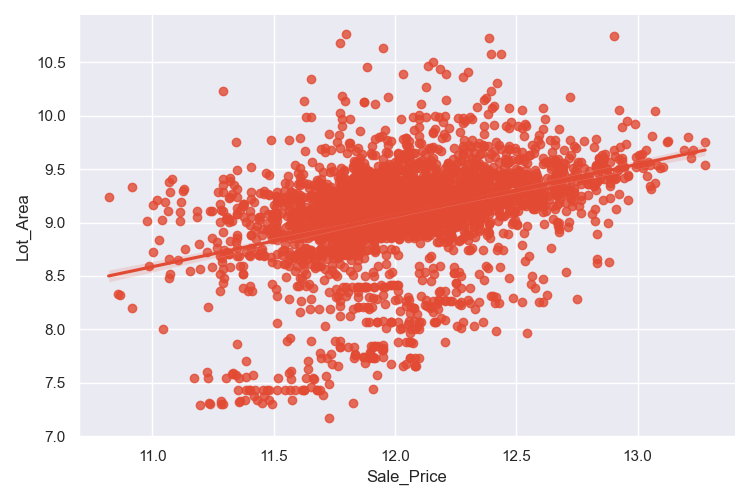

In [392]:
scatterplot_single(df,'Sale_Price', 'Lot_Area')

We can tell that we find many outliers here

In [395]:
df['Price_SF'] = df['Sale_Price']/df['Lot_Area']

<IPython.core.display.Javascript object>


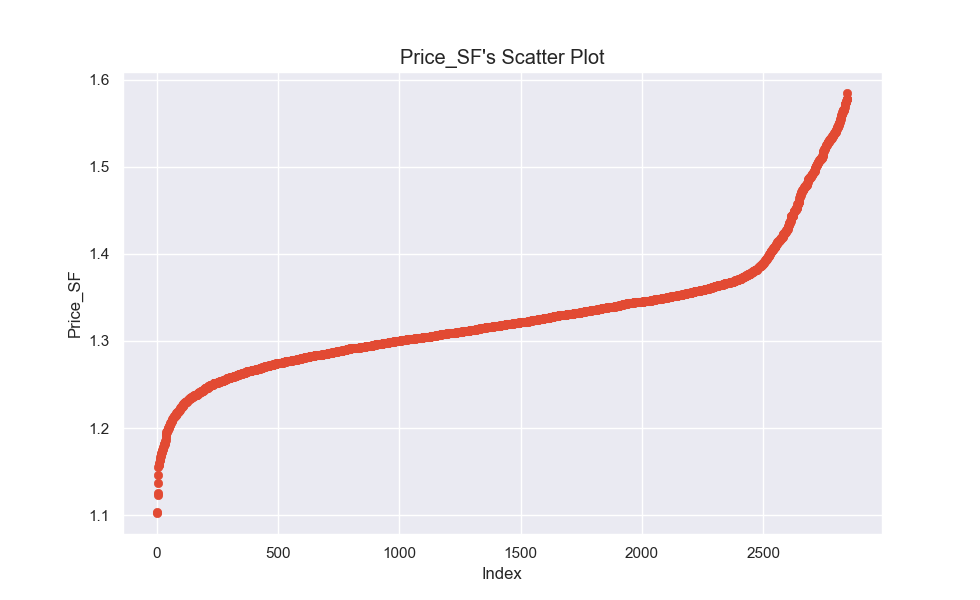

In [396]:
scatterplot_distr(df.drop(df[(df['Price_SF']>1.6) | (df['Price_SF']<1.1)].index.tolist(),axis=0), 'Price_SF')

This is a strange pattern to see

## Seasonality related features vs Sale Price

https://www.bankrate.com/real-estate/best-time-to-sell-house/

We can easily see that the houses were sold between 2006 and 2010. This means it includes trends of the global state of the economy during the crisis in 2008.

We can divide the years by seasons:
1. December-March
2. April-July, which are supposed to be the best months for selling
3. August-November

In [397]:
def seasonality_df(dataset, target, years_col, months_col):
    d = dataset[[target, years_col, months_col]].groupby([years_col, months_col]).describe()
    d.columns = d.columns.droplevel()
    d = d.reset_index()
    return d.drop(columns=['std', '25%', '75%']).rename(columns={'50%':'median'})


def target_by_year_month(dataset, target, highlight):
    d = seasonality_df(dataset=dataset, target=target, years_col='Year_Sold',
                      months_col = 'Mo_Sold')
    
    grid = sns.FacetGrid(d, 
                         col="Year_Sold",
                         palette="tab20c", 
                         col_wrap=5, height=3)

    grid.map(plt.plot, "Mo_Sold", highlight, marker="o")
    
    grid.set(xticks=np.arange(13),
             xlim=(0, 13), 
             xlabel ='Month', ylabel= highlight.capitalize())
    
    grid.fig.tight_layout(w_pad=0.5)
    pass

<IPython.core.display.Javascript object>


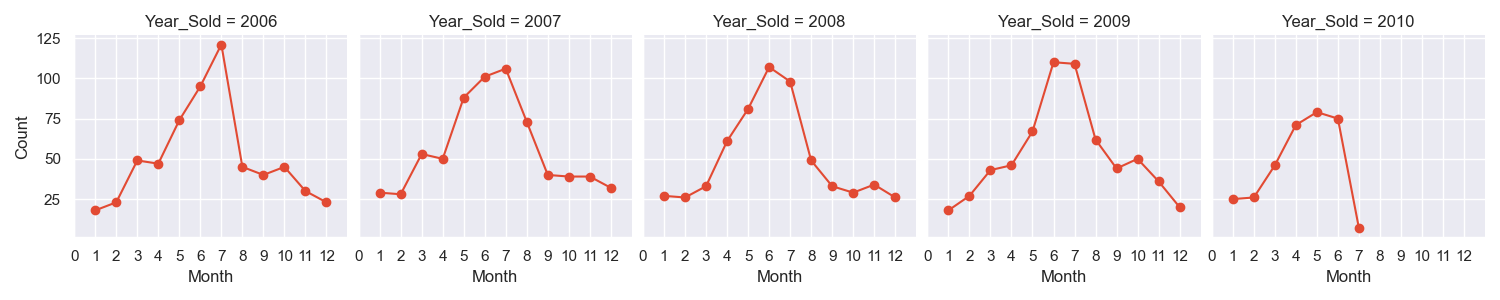

In [398]:
target_by_year_month(df, target='Sale_Price', highlight='count')

The central months seem to be the preferred months to sell a house from our sample.

<IPython.core.display.Javascript object>


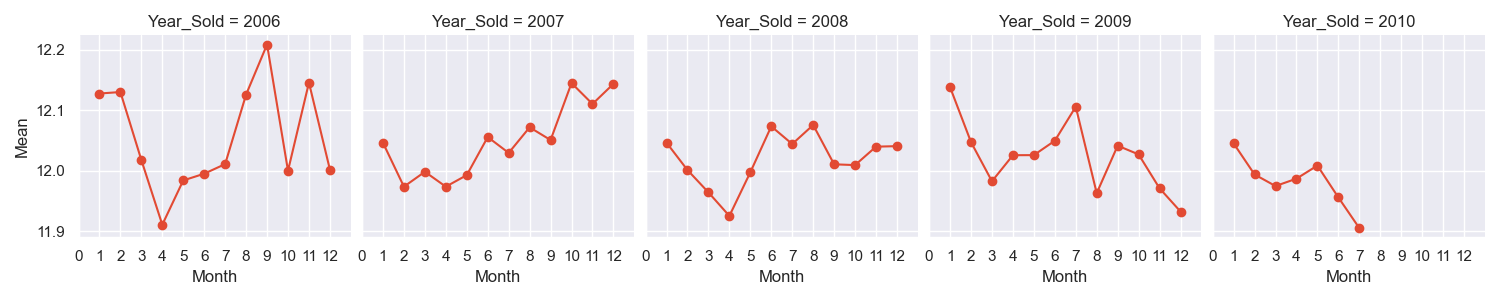

In [399]:
target_by_year_month(df, target='Sale_Price', highlight='mean')

However we do see a big drop during 2008 and a negative trend from 2009 to 2010!

## Location related features vs Sale Price

### Street vs Sale Price

### Neighborhood vs Sale Price

In [400]:
def stripplot_single(dataset, target, categ_feat, figsize=None):
    if figsize is None:
        fig, ax = plt.subplots(figsize=(11,7))
    else:
        fig,ax = plt.subplots(figsize=figsize)
    
    sns.stripplot(y=categ_feat, x =target, data =dataset, jitter = True, dodge = True, ax=ax)
    pass

<IPython.core.display.Javascript object>


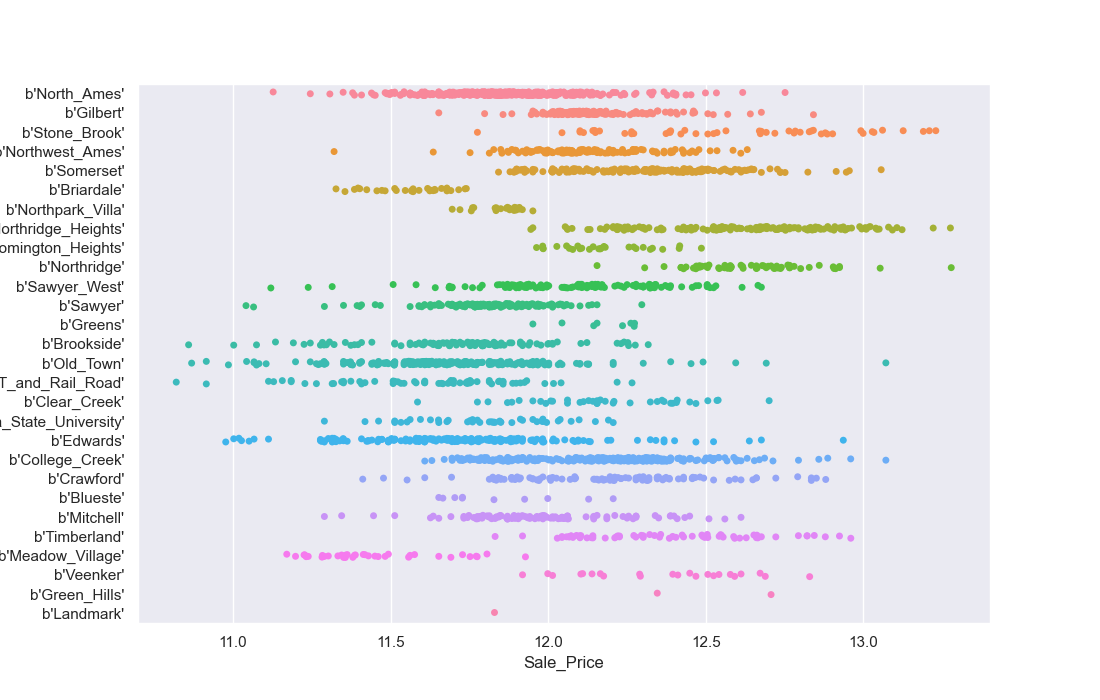

In [401]:
stripplot_single(dataset=df, categ_feat ='Neighborhood', target ='Sale_Price')

From this plot we can conclude the neighborhood per-se does not reall help, we should encode the ordinal variables which evaluate the conditions and quality of the buildings and then construct a variable that evaluates the real overall condition of the location. If we decided to encode all the neighborhoods we would have too many labels and it would not lead us to any improvement as there are few observations for many of them.

In [ ]:
df['Location'] = ((df['OverallQual']/df['OverallQual'].mean()) 
                        + (df['OverallCond']/df['OverallCond'].mean())
                        + (df['ExterQual_Num']/df['ExterQual_Num'].mean())
                        + (dft['ExterCond_Num']/df['ExterCond_Num'].mean()) 
                        + (df['Functional_Num']/df['Functional_Num'].mean()))

---

## Age related features vs Sale Price

As predicted the following features show a high correlation with the price.
* Year_Built
* Year_Remod_Add
* Age

### Year Built vs Sale Price

<IPython.core.display.Javascript object>


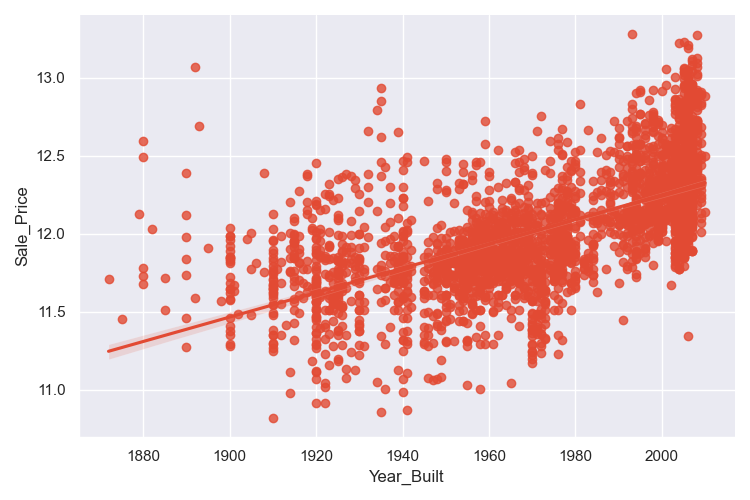

In [410]:
scatterplot_single(df, 'Year_Built', 'Sale_Price')

As we all know this does not represent the true relationship, as the real age of the building usually influences more the sale price

### Year Remod Add vs Sale Price

<IPython.core.display.Javascript object>


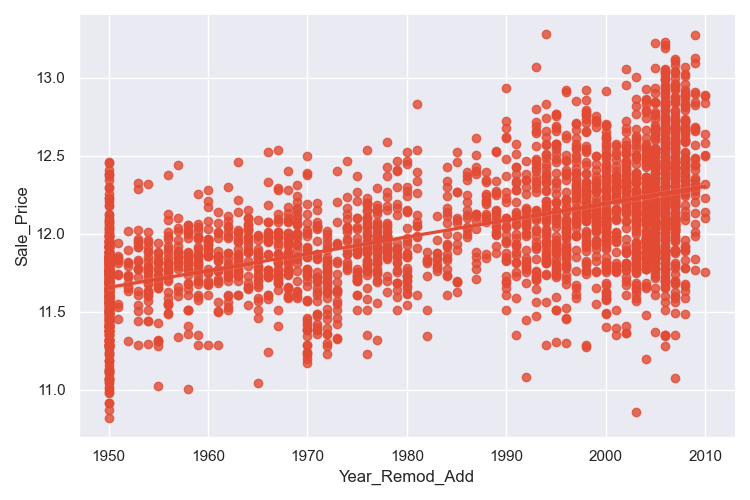

In [411]:
scatterplot_single(df, 'Year_Remod_Add', 'Sale_Price')

From our results we found out that these two features have some correlation between them, let's see how do they change together

### Year Remod Add vs Year Built

<IPython.core.display.Javascript object>


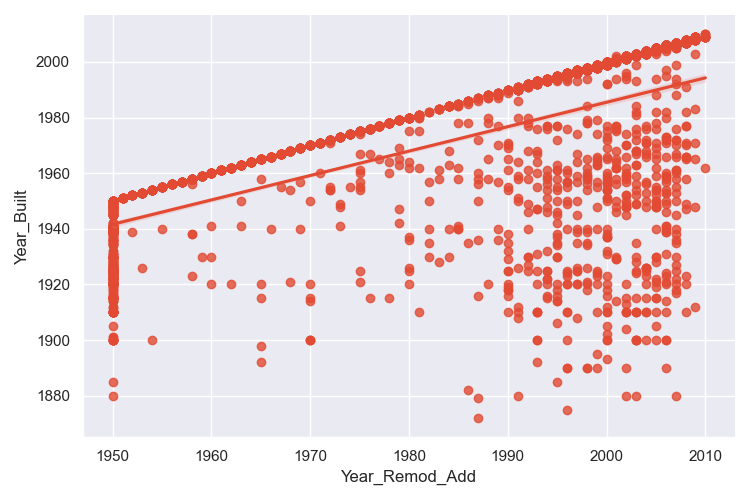

In [412]:
scatterplot_single(df, 'Year_Remod_Add', 'Year_Built')

We can see that many houses were never remodeled, as they year of remodeling is the same year the houses were built .

To explore even more the aspect of the age and quality of the buildings we want to find how the aging process contributed to the price.

In [87]:
# Adding structure age variable depending if there was a major remodeling
df['Age'] = df.apply(lambda x: x['Year_Sold']-x['Year_Built'] if (x['Year_Built']<x['Year_Remod_Add']) 
                                                           else (x['Year_Sold']-x['Year_Remod_Add']), axis=1)

### Age vs Sale Price

<IPython.core.display.Javascript object>


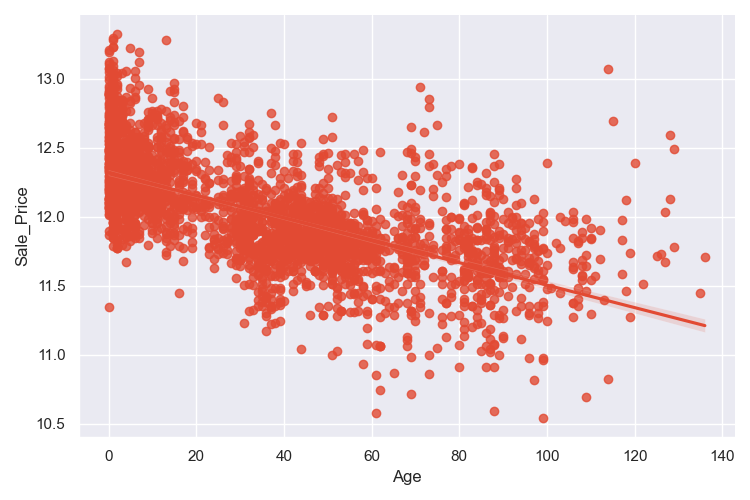

In [88]:
scatterplot_single(df, 'Age', 'Sale_Price')

As we can tell, the relationship is negative as the price decreaseases as time goes by without any remodeling.

The high correlation between these features was a result of the fact that `Year_Remod_Add` takes the same values as `Year_Built` for houses that were never renewed. 

Now we should decide whether to keep just one of the two or to apply other transformations. However an indicator could be useful

In [89]:
df['Remodeled'] = df.apply(lambda x: 0 if (x['Year_Built'] == x['Year_Remod_Add']) 
                                                           else (1), axis=1)

<IPython.core.display.Javascript object>


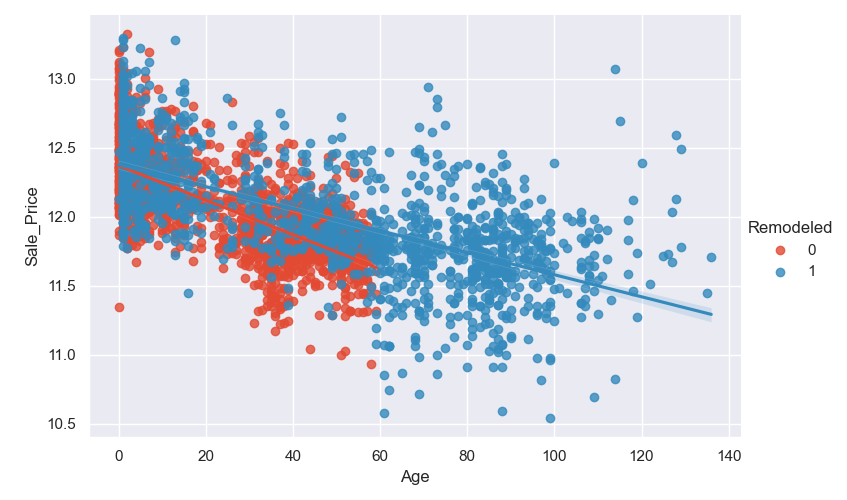

In [90]:
scatterplot_single(df, 'Age', 'Sale_Price', hue='Remodeled')

As predicted, house prices lower faster when the age of the building goes up, but the relationship still shows a lot of variance for price prediction.

---

## Above ground living related features vs Sale Price
* Gr_Liv_Area
* Fireplaces
* Full_Bath
* First_Flr_SF, Second_Flr_SF
* TotRms_AbvGrd

### First Flr SF vs Sale Price

<IPython.core.display.Javascript object>


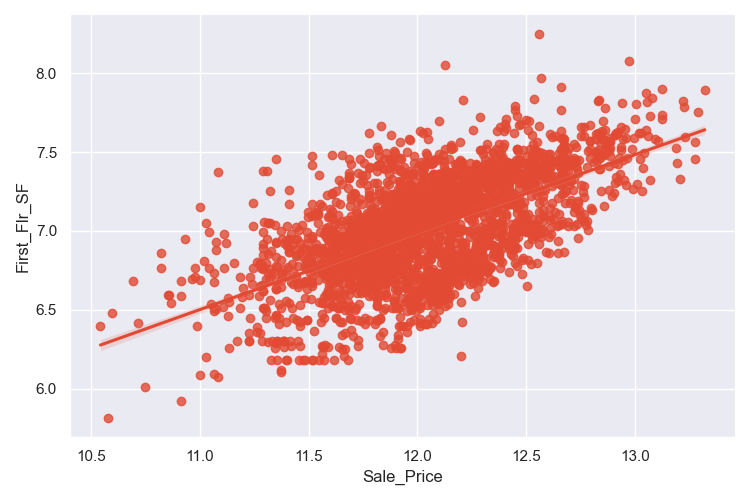

In [91]:
scatterplot_single(df, 'Sale_Price','First_Flr_SF')

The area of the first floor is positively correlated with `Sale_Price` as we expected, and there is not much variance too. To analyze the second floor against the sale price, we want to add an indicator just to see if the presence of 1+ floors affects the price in a different manner.

In [92]:
df['Flr_AbvGrd'] = df.apply(lambda x: 1 if(x['Second_Flr_SF']>0.0) else 2,axis=1)

### Second Flr SF vs Sale Price

<IPython.core.display.Javascript object>


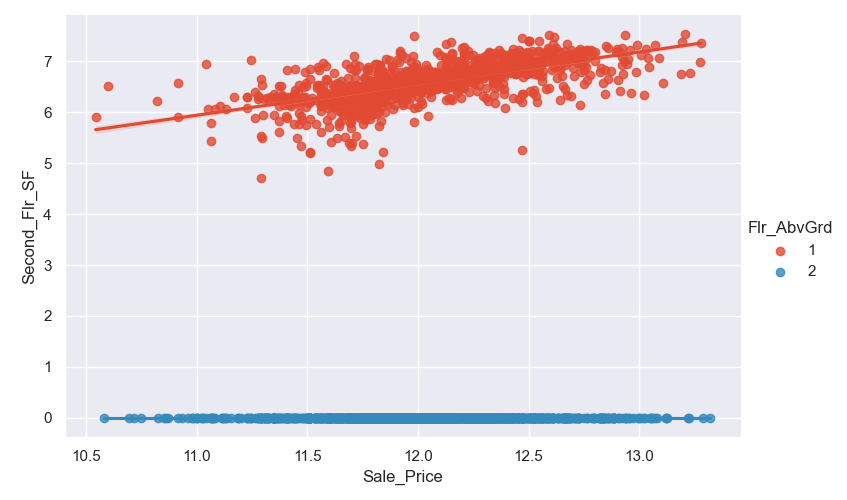

In [93]:
scatterplot_single(df, 'Sale_Price','Second_Flr_SF', hue='Flr_AbvGrd')

We can definitely see a change in the linear prediction when the price is affected by the presence of a second floor.

### Gr Liv Area vs Sale Price

<IPython.core.display.Javascript object>


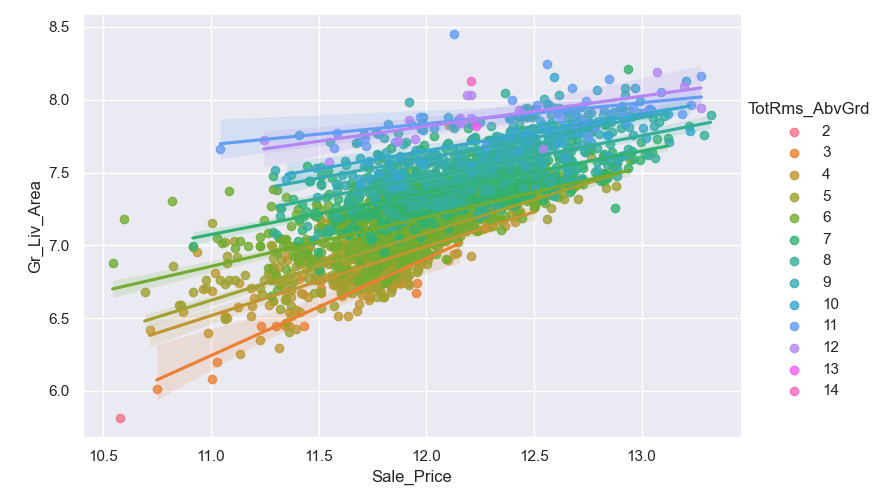

In [94]:
scatterplot_single(df, 'Sale_Price','Gr_Liv_Area', hue='TotRms_AbvGrd')

There sure is a positive relationship between these two features which is also highly affected by the number of rooms above ground each houses has. By removing the outliers, the correlation increases.

In [95]:
df.drop(df[(df['TotRms_AbvGrd']<3)| (df['TotRms_AbvGrd']>12)].index.tolist(), inplace=True)

### Tot Rms Abv Grd vs Sale Price

<IPython.core.display.Javascript object>


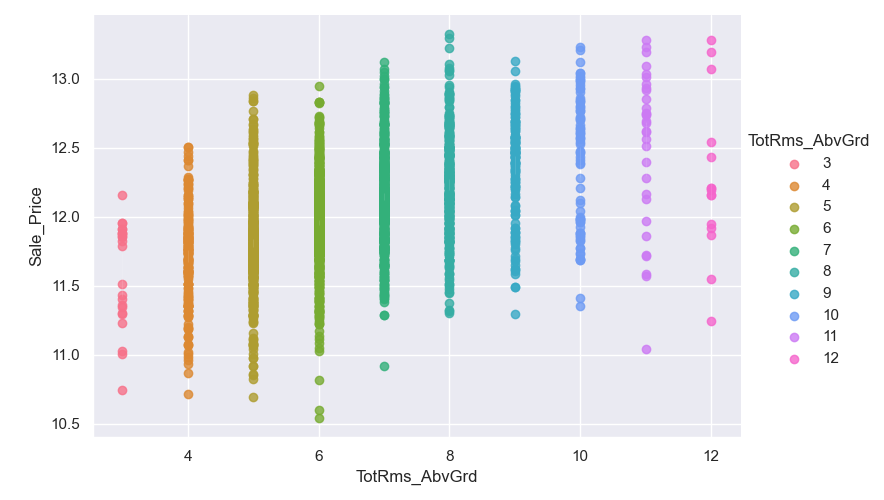

In [96]:
scatterplot_single(df, 'TotRms_AbvGrd','Sale_Price', hue='TotRms_AbvGrd')

### Tot Rms Abv Grd vs Gr Liv Area

<IPython.core.display.Javascript object>


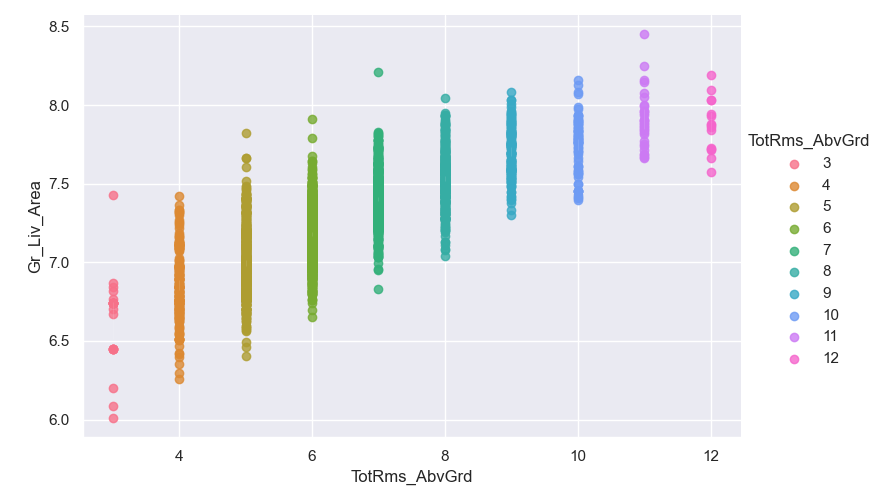

In [97]:
scatterplot_single(df, 'TotRms_AbvGrd','Gr_Liv_Area', hue='TotRms_AbvGrd')

In [100]:
df.drop(df[(df['Gr_Liv_Area']>7.0)&(df['TotRms_AbvGrd']<=3)].index.tolist(), inplace=True)
df.drop(df[(df['Gr_Liv_Area']>7.5)&(df['TotRms_AbvGrd']<=5)].index.tolist(), inplace=True)
df.drop(df[(df['Gr_Liv_Area']>7.75)&(df['TotRms_AbvGrd']<=6)].index.tolist(), inplace=True)
df.drop(df[(df['Gr_Liv_Area']>8.0)&(df['TotRms_AbvGrd']<=7)].index.tolist(), inplace=True)
df.drop(df[(df['Gr_Liv_Area']>8.4)&(df['TotRms_AbvGrd']<=11)].index.tolist(), inplace=True)
df.drop(df[(df['Gr_Liv_Area']>8.4)&(df['TotRms_AbvGrd']<=11)].index.tolist(), inplace=True)

In [101]:
df['Rms_Gr_Area_Ratio']= df['TotRms_AbvGrd']/df['Gr_Liv_Area']

### Rms Gr Area Ratio vs Sale Price

<IPython.core.display.Javascript object>


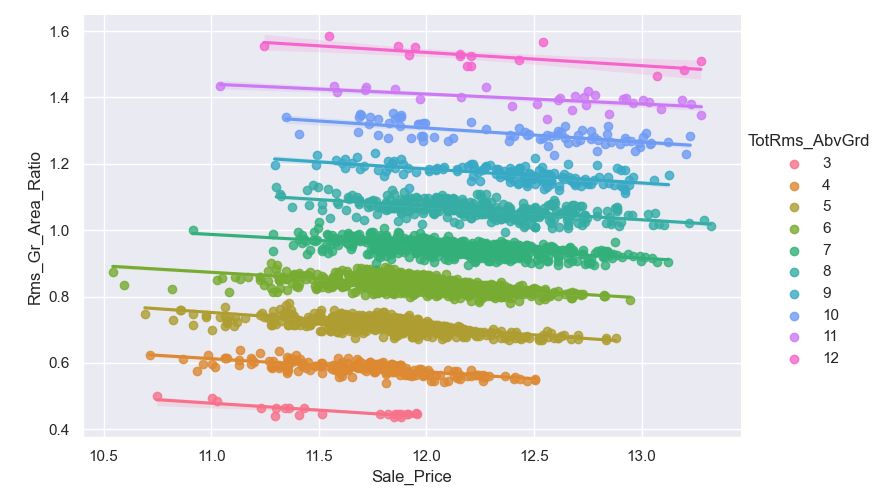

In [102]:
scatterplot_single(df,'Sale_Price', 'Rms_Gr_Area_Ratio', hue='TotRms_AbvGrd')

### Full bath vs Sale Price

<IPython.core.display.Javascript object>


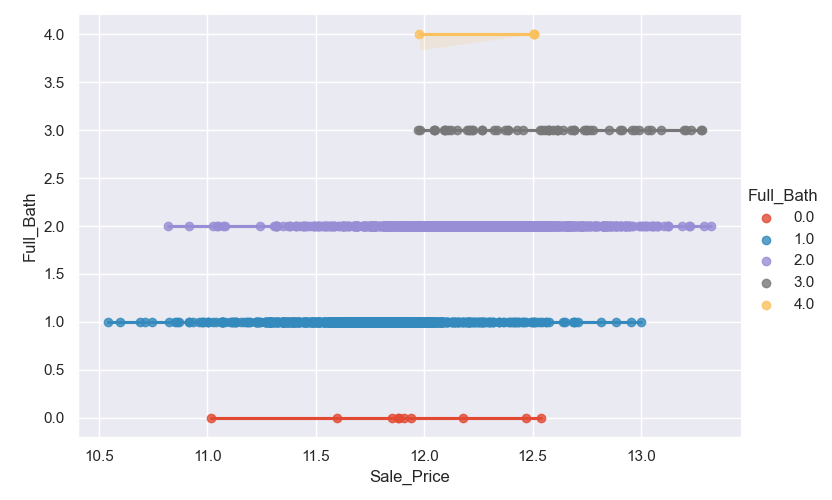

In [103]:
scatterplot_single(df,'Sale_Price', 'Full_Bath', hue='Full_Bath')

### Half bath vs Sale Price

<IPython.core.display.Javascript object>


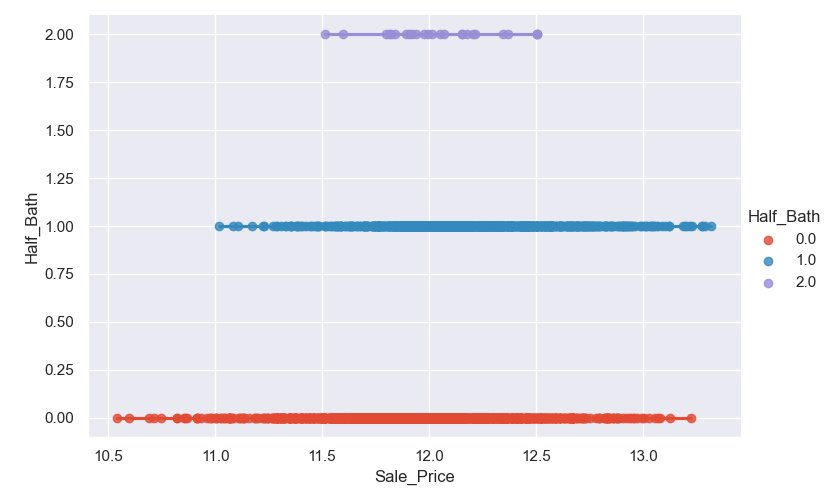

In [104]:
scatterplot_single(df,'Sale_Price', 'Half_Bath', hue='Half_Bath')

### Total bath vs Sale Price

In [105]:
df['Total_Bath'] = df['Full_Bath'] + (df['Half_Bath'] * 0.5)

<IPython.core.display.Javascript object>


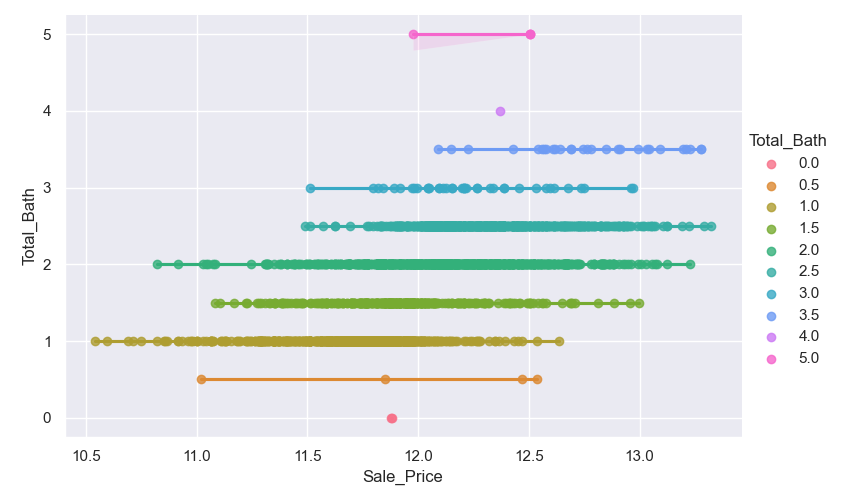

In [106]:
scatterplot_single(df,'Sale_Price', 'Total_Bath', hue='Total_Bath')

### Full bath vs Gr Liv Area

<IPython.core.display.Javascript object>


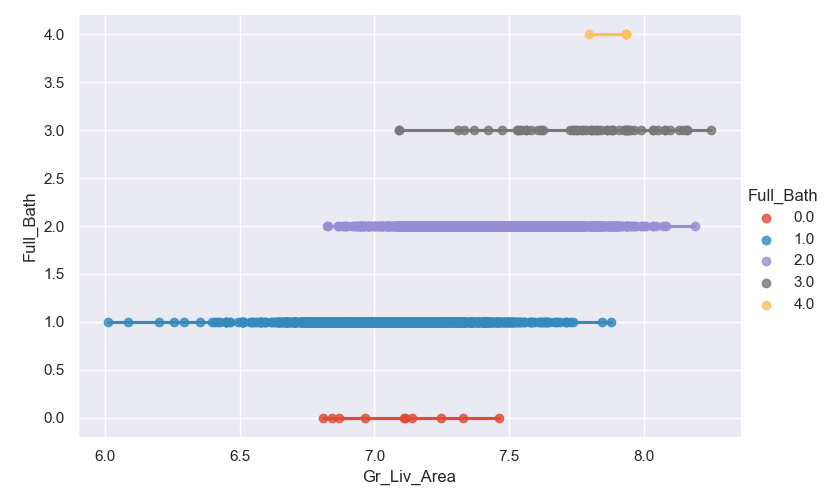

In [107]:
scatterplot_single(df,'Gr_Liv_Area', 'Full_Bath', hue='Full_Bath')

In [110]:
df.drop(df[(df['Gr_Liv_Area']<=6.3)&(df['Full_Bath']==1.0)].index.tolist(), inplace=True)
df.drop(df[(df['Gr_Liv_Area']<=7.3)&(df['Full_Bath']==3.0)].index.tolist(), inplace=True)

In [111]:
df['TBath_Gr_Area_Ratio'] = df.apply(lambda x : x['Gr_Liv_Area']/x['Total_Bath'] if(x['Total_Bath']!=0.0) else 0.0, axis=1)

### TBath_Gr_Area_Ratio vs Sale Price

<IPython.core.display.Javascript object>


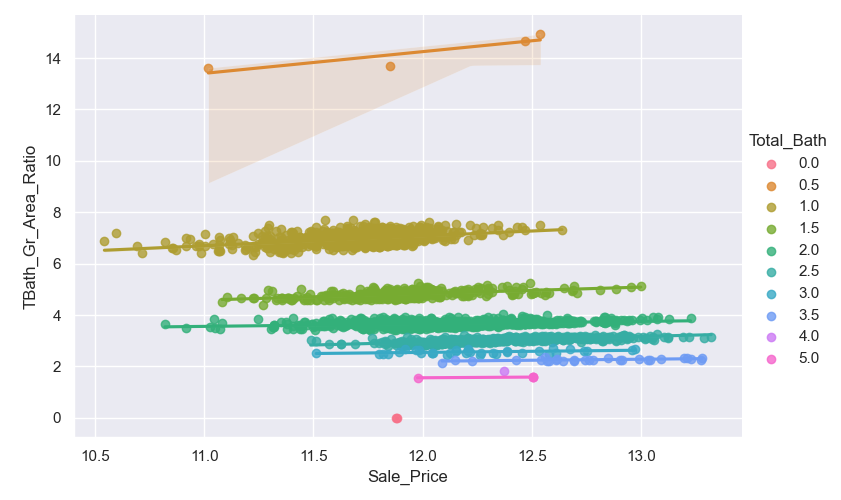

In [112]:
scatterplot_single(df,'Sale_Price', 'TBath_Gr_Area_Ratio', hue='Total_Bath')

### Bedrooms vs Sale Price

<IPython.core.display.Javascript object>


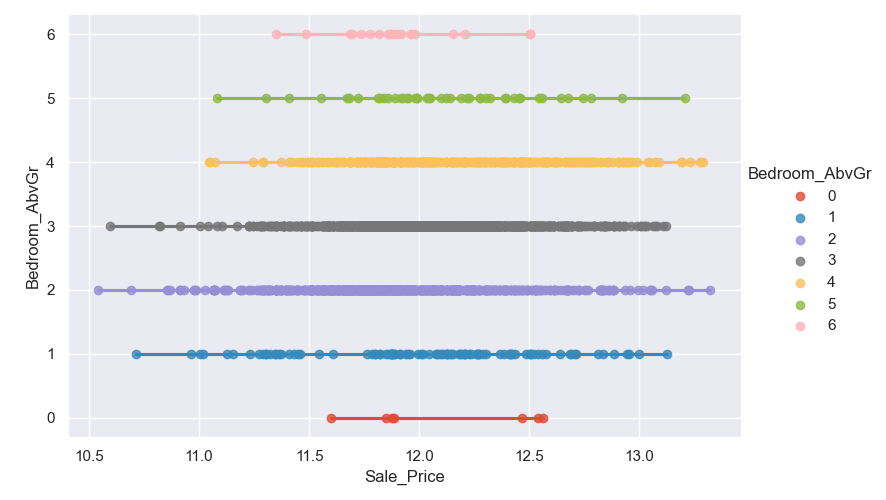

In [113]:
scatterplot_single(df, 'Sale_Price','Bedroom_AbvGr', hue='Bedroom_AbvGr')

In [116]:
### Bedrooms vs Gr Liv Area

<IPython.core.display.Javascript object>


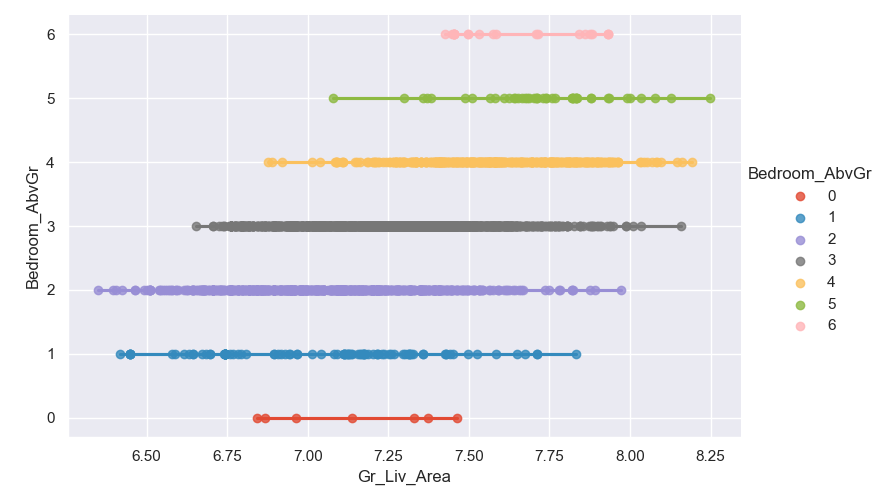

In [117]:
scatterplot_single(df, 'Gr_Liv_Area','Bedroom_AbvGr', hue='Bedroom_AbvGr')

In [120]:
df['Bedroom_Liv_Area_Ratio'] = df.apply(lambda x : x['Gr_Liv_Area']/x['Bedroom_AbvGr'] if(x['Bedroom_AbvGr']!=0.0) else 0.0, axis=1)

<IPython.core.display.Javascript object>


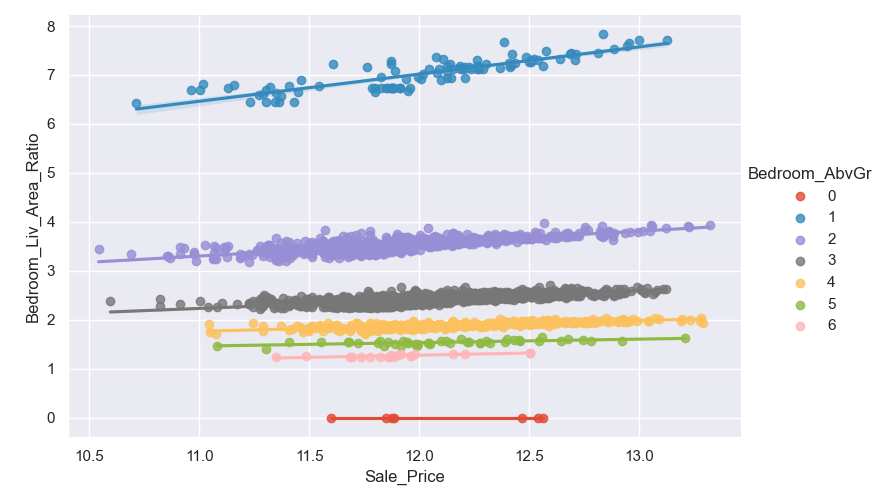

In [121]:
scatterplot_single(df, 'Sale_Price','Bedroom_Liv_Area_Ratio', hue='Bedroom_AbvGr')

### Fireplace vs Sale Price

<IPython.core.display.Javascript object>


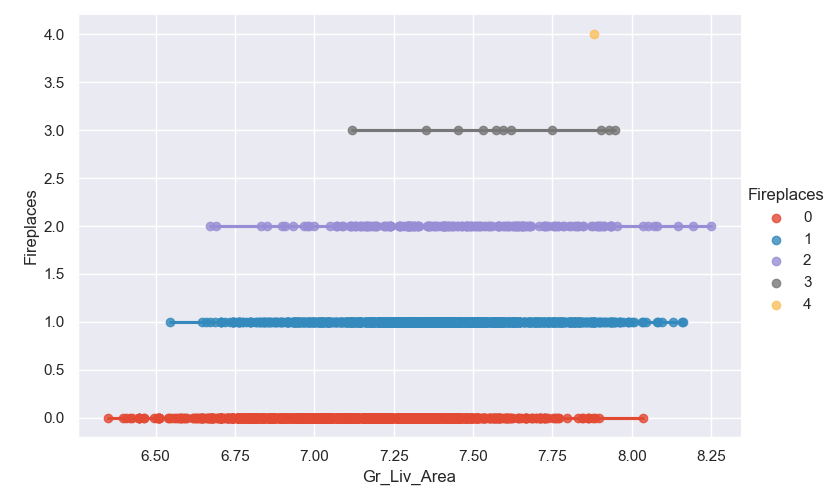

In [125]:
scatterplot_single(df,'Gr_Liv_Area', 'Fireplaces', hue='Fireplaces')

In [129]:
df['Fireplace_Gr_Area_Ratio'] = df.apply(lambda x : x['Gr_Liv_Area']/x['Fireplaces'] if(x['Fireplaces']!=0.0) else 0.0, axis=1)

### Fireplace Gr_Area Ratio vs Sale Price

<IPython.core.display.Javascript object>


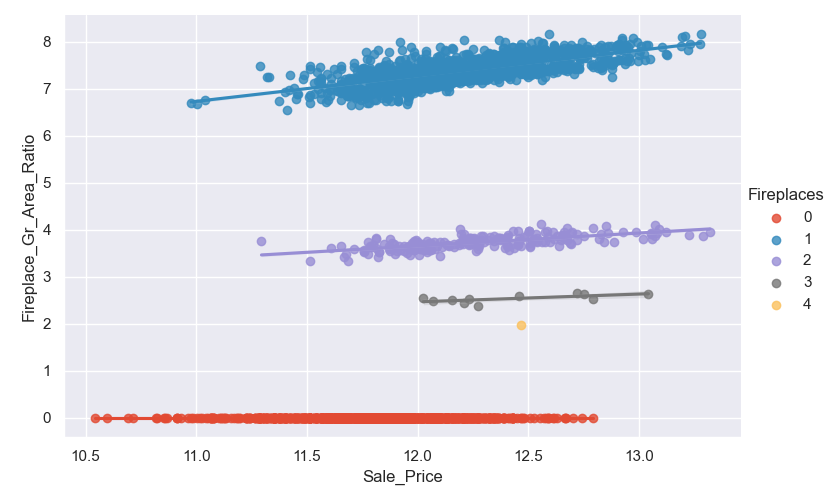

In [127]:
scatterplot_single(df,'Sale_Price', 'Fireplace_Gr_Area_Ratio', hue='Fireplaces')

## Garage related features vs Sale Price
* Garage_Cars
* Garage_Area
* Garage_Cond
* Garage_Qual
* Garage_Type
* Garage_Finish

### Garage Area vs Sale Price

As we can predict, there will be instances without any garage. Let us add another indicator.

<IPython.core.display.Javascript object>


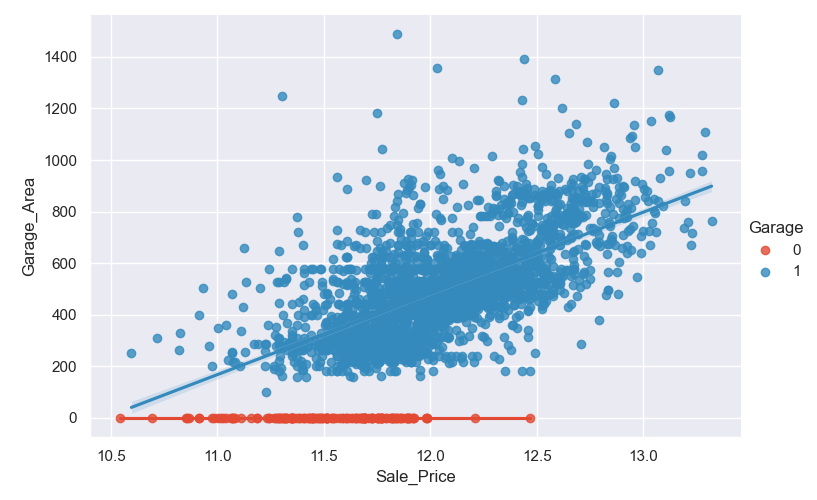

In [128]:
scatterplot_single(df, target='Sale_Price', label='Garage_Area', hue='Garage')

In [130]:
df_garage = df.loc[:,df.columns.isin(['Garage_Type', 'Garage_Area', 'Garage_Cars', 'Garage_Cond', 'Garage_Qual', 'Garage_Finish'])]
outliers = df_garage[(df_garage['Garage_Area'] == 0.0) & (df_garage['Garage_Type'] != (b'No_Garage'))]
df = df.drop(outliers.index)

<IPython.core.display.Javascript object>


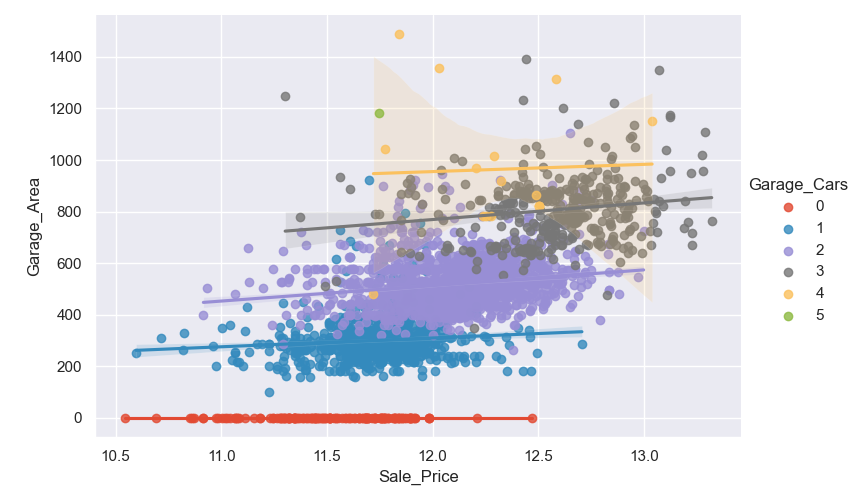

In [131]:
scatterplot_single(df, target='Sale_Price', label='Garage_Area', hue='Garage_Cars')

This looks like an outlier for sure, just by looking at the prices we can see there is an increasing trend for prices! 

In [132]:
df.drop(df.loc[df['Garage_Cars']>4].index.tolist(), inplace=True)

Well they seem to show different behavior for each different count of cars. Let us try and inspect the garage related features in depth

<IPython.core.display.Javascript object>


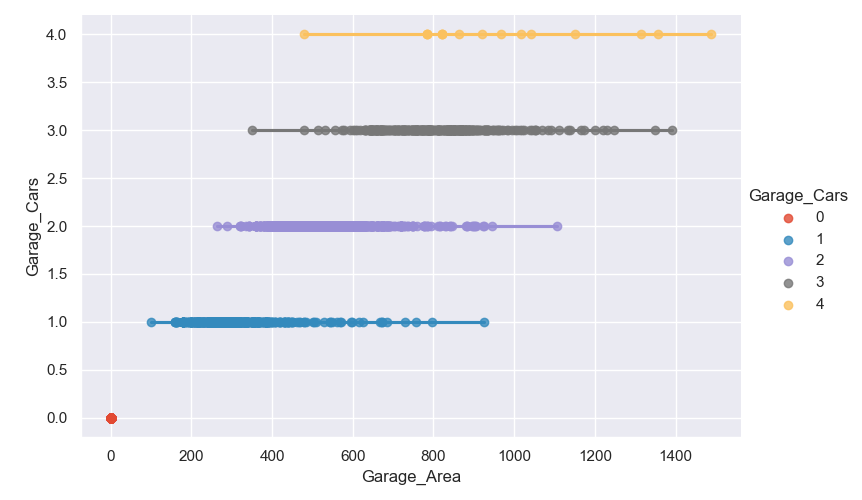

In [133]:
scatterplot_single(df, target='Garage_Area', label='Garage_Cars', hue='Garage_Cars')

It is interesting to see that there seems to be a good correlation between these two features. Let's add this inside our dataframe

<IPython.core.display.Javascript object>


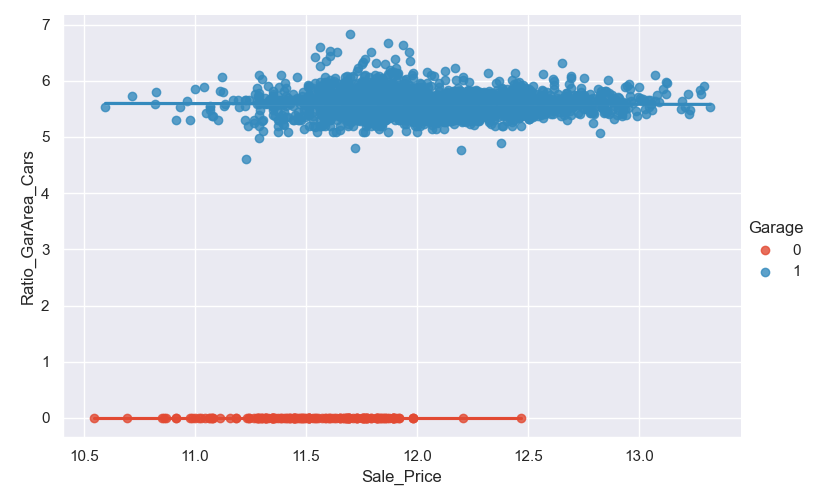

In [134]:
df['Ratio_GarArea_Cars']= np.log1p((df['Garage_Area']/df['Garage_Cars']).fillna(0.0))
scatterplot_single(df, target='Sale_Price', label='Ratio_GarArea_Cars', hue='Garage')

There is an evident trend between the sale price and our new feature, but the fact that many houses do not have a garage and still seem to increase in price can be a problem.

## Basement related features vs Sale Price

### Total Bsmt SF vs Sale Price

<IPython.core.display.Javascript object>


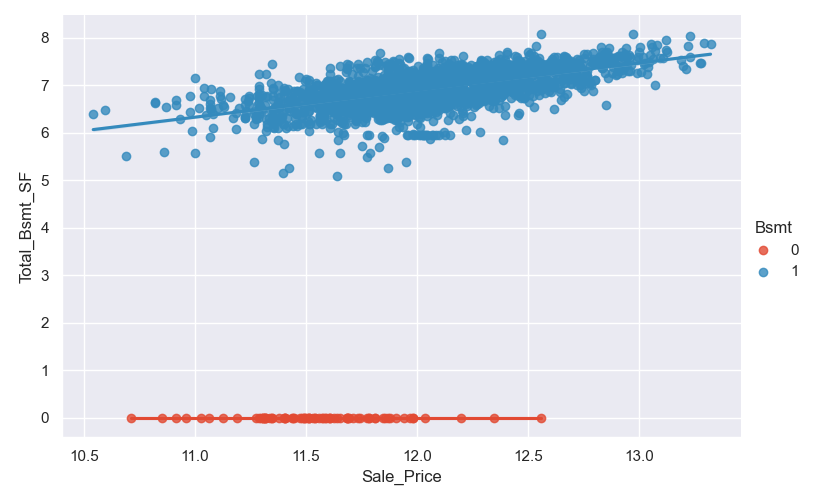

In [135]:
scatterplot_single(df, 'Sale_Price', 'Total_Bsmt_SF', hue='Bsmt')

In [136]:
get_cols(df, 'Bsmt')

['BsmtFin_SF_1',
 'BsmtFin_SF_2',
 'BsmtFin_Type_1',
 'BsmtFin_Type_2',
 'Bsmt_Cond',
 'Bsmt_Exposure',
 'Bsmt_Full_Bath',
 'Bsmt_Half_Bath',
 'Bsmt_Qual',
 'Bsmt_Unf_SF',
 'Total_Bsmt_SF',
 'Bsmt_Fin_SF',
 'Bsmt']

### Bsmt_Unf_SF

<IPython.core.display.Javascript object>


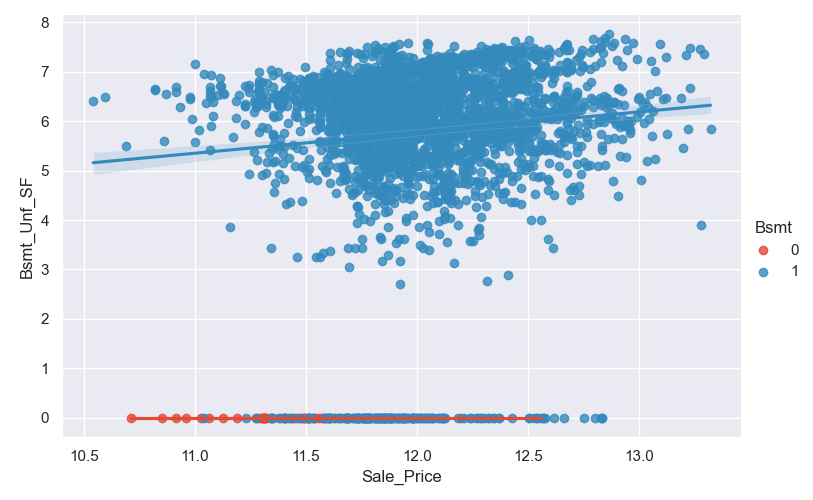

In [137]:
scatterplot_single(df, 'Sale_Price', 'Bsmt_Unf_SF', hue='Bsmt')

We cannot really make a use of it

### Bsmt Fin SF vs Sale Price

<IPython.core.display.Javascript object>


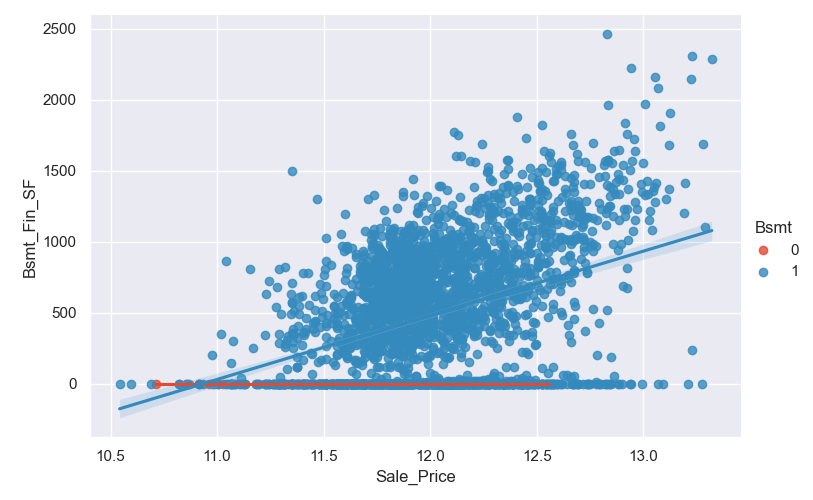

In [138]:
scatterplot_single(df, 'Sale_Price', 'Bsmt_Fin_SF', hue='Bsmt')

And again here it seems like we can discard this feature

## External related features vs Sale Price
* Mas_Vnr_Area
* Porch related features
* Deck related features

### Mas_Vnr_Area

<IPython.core.display.Javascript object>


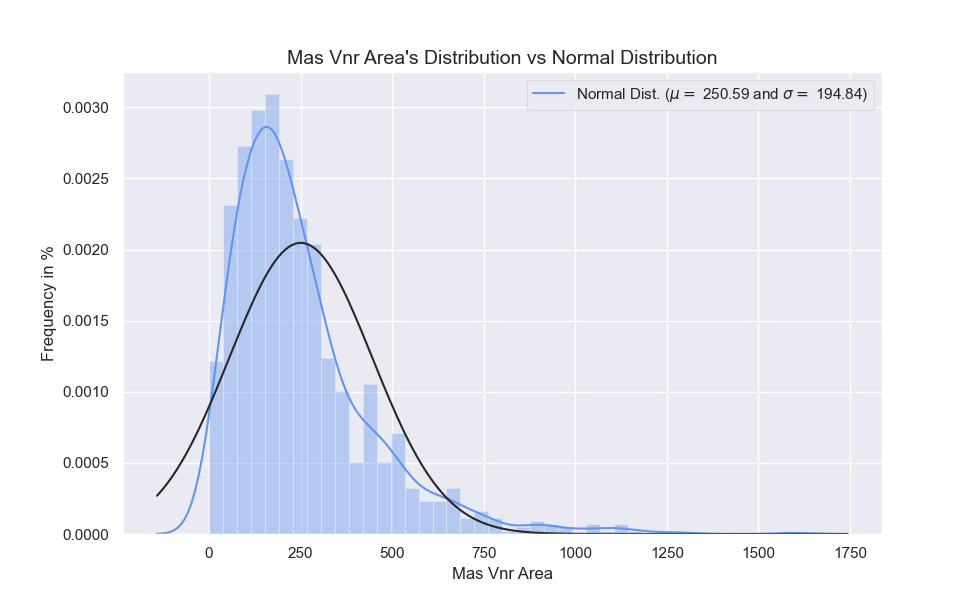

In [139]:
numeric_distr_plot(df.drop(df[df['Mas_Vnr_Area']==0].index.tolist()), 'Mas_Vnr_Area')

This suggests a logarithmic transformation

In [140]:
df['Mas_Vnr_Area'] = np.log1p(df['Mas_Vnr_Area'])

<IPython.core.display.Javascript object>


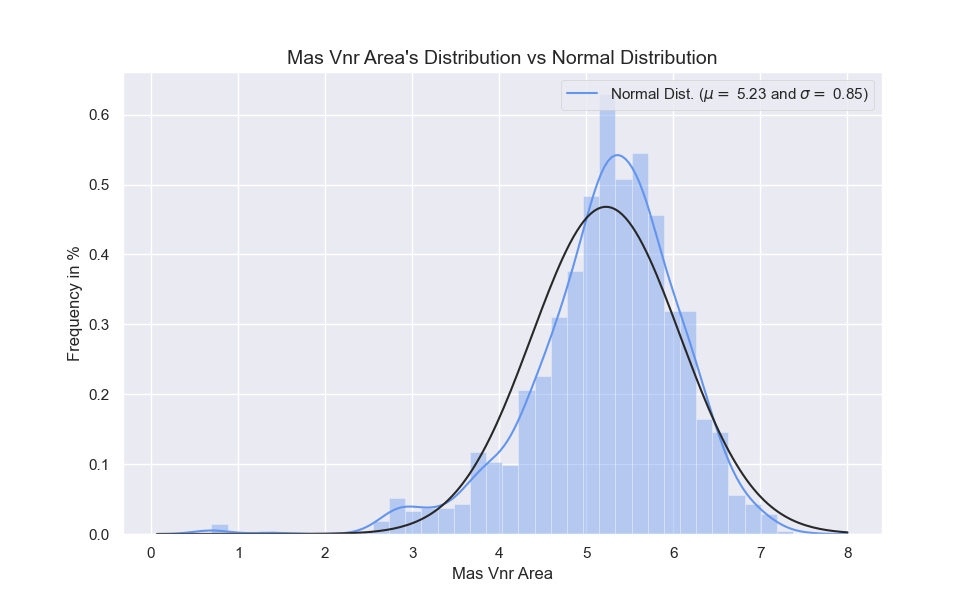

In [141]:
numeric_distr_plot(df.drop(df[df['Mas_Vnr_Area']==0].index.tolist()), 'Mas_Vnr_Area')

In [142]:
df['Mas_Vnr'] = df.apply(lambda x: 0 if (x['Mas_Vnr_Area']<=0.0) else 1 ,axis=1)

<IPython.core.display.Javascript object>


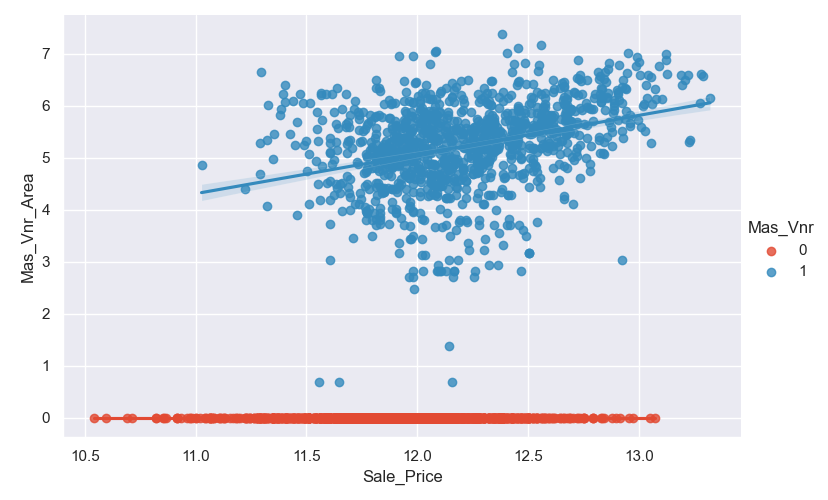

In [143]:
scatterplot_single(df,'Sale_Price', 'Mas_Vnr_Area', hue='Mas_Vnr')

## Sale related features vs Price

Then, I looked into the “SaleCondition” variable, which recorded the type of sales for each transaction, Most observations were in the “Normal” sale category, but there were 218 observations recorded as either “Abnormal” or “Family” (intra-family sale). I zoomed in on these, and noted that both their mean and median sale prices (and price per square foot) were well below those of the overall sample. This prompted me to exclude these 218 unusual sale transactions from the analysis. If these transactions were not primarily commercial in nature, then their inclusion in the dataset would introduce bias into a model trying to estimate the economic relationship between housing characteristics and house prices.

## VIF

One-Hot Encoding results in a Dummy Variable Trap as the outcome of one variable can easily be predicted with the help of the remaining variables.

Dummy Variable Trap is a scenario in which variables are highly correlated to each other.

The Dummy Variable Trap leads to the problem known as multicollinearity. Multicollinearity occurs where there is a dependency between the independent features. Multicollinearity is a serious issue in machine learning models like Linear Regression and Logistic Regression.

So, in order to overcome the problem of multicollinearity, one of the dummy variables has to be dropped. Here, I will practically demonstrate how the problem of multicollinearity is introduced after carrying out the one-hot encoding.

One of the common ways to check for multicollinearity is the Variance Inflation Factor (VIF):

VIF=1, Very Less Multicollinearity
VIF<5, Moderate Multicollinearity
VIF>5, Extreme Multicollinearity (This is what we have to avoid)
Compute the VIF scores:

In [545]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(dataset):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = dataset.columns
    vif_data["VIF"] = [variance_inflation_factor(dataset.values, i) 
                       for i in range(dataset.shape[1])]
    vif_data = vif_data[vif_data['Variable']!='intercept']
    print(vif_data)
    pass

In [ ]:
df.to_csv(os.path.join(RESOURCES_DIR, "ames_housing_out_2.csv"))

---

# Credits & Copyright

Domain Knowledge
 
 @misc{johnson_2022, title={4 best ways to determine home value}, url={https://www.rocketmortgage.com/learn/home-value}, journal={Rocket Mortgage}, author={Johnson, Jamie}, year={2022}, month={Sep}} 
 
  @misc{gomez_2022, title={8 critical factors that influence a home's value}, url={https://www.opendoor.com/w/blog/factors-that-influence-home-value}, journal={Opendoor}, author={Gomez, Joe}, year={2022}, month={Aug}} 
 

Helpful articles
* [Project 2: Predicting Housing Prices with Linear Regression](https://www.benjamindornel.com/ames-regression.html)
* [Cracking the Ames Housing Dataset with Linear Regression](https://towardsdatascience.com/wrangling-through-dataland-modeling-house-prices-in-ames-iowa-75b9b4086c96)
* 

Helpful notebooks
* [Exploratory Data Analysis of Housing in Ames, Iowa](https://www.kaggle.com/code/leeclemmer/exploratory-data-analysis-of-housing-in-ames-iowa) by *Lee Clemmer*
* [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard) by *SERIGNE*
* [Gimme Shelter 🏠 SCORE 0.12630](https://www.kaggle.com/code/gkitchen/gimme-shelter-score-0-12630) by *GKITCHEN*
* [House Price - Advanced Regression](https://www.kaggle.com/code/thisishusseinali/house-price-advanced-regression) by *HUSSEIN ALI*
* [House Prices - Pipeline, Ensemble Models](https://www.kaggle.com/code/rushikeshsawarkar/0-12018-house-prices-pipeline-ensemble-models) by *RUSHIKESH SAWARKAR*